Configuración inicial completada.
Funciones de procesamiento de datos cargadas.
Funciones de modelos y entrenamiento cargadas.
Funciones de visualización cargadas.
Funciones de predicción cargadas.
Cargando datos...
Datos cargados correctamente: 662 registros, 72 columnas

Primeras 3 filas del dataset:
        Jugador  Temporada      Fecha   Equipo   Oponente  Goles  Asistencias Día de la semana  Sede Titular  Minutos  Penales marcados  Penales intentados  Tiros totales  Tiros a puerta  Tarjetas amarillas  Tarjetas rojas  Faltas cometidas  Faltas recibidas  Fuera de juego  Centros  Entradas ganadas  Intercepciones  Goles en propia  Penales ganados  Penales concedidos   Año  Mes Equipo_Estandarizado  Equipo_Es_Colombiano Equipo_Bucaramanga Equipo_Independiente Santa Fe Equipo_Junior Equipo_Millonarios Equipo_Once Caldas Equipo_Pereira Equipo_Rionegro Oponente_Estandarizado  Oponente_Es_Colombiano Oponente_Alianza FC Oponente_Atlético Huila Oponente_Atlético Nacional Oponente_Boyacá Chic

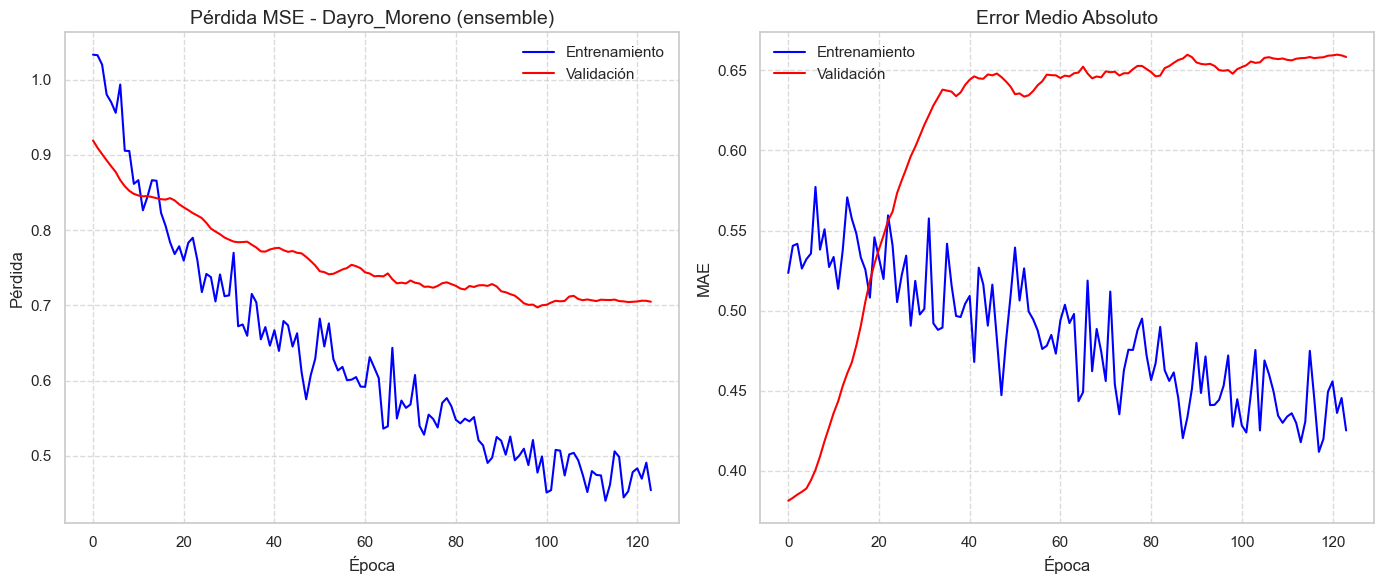

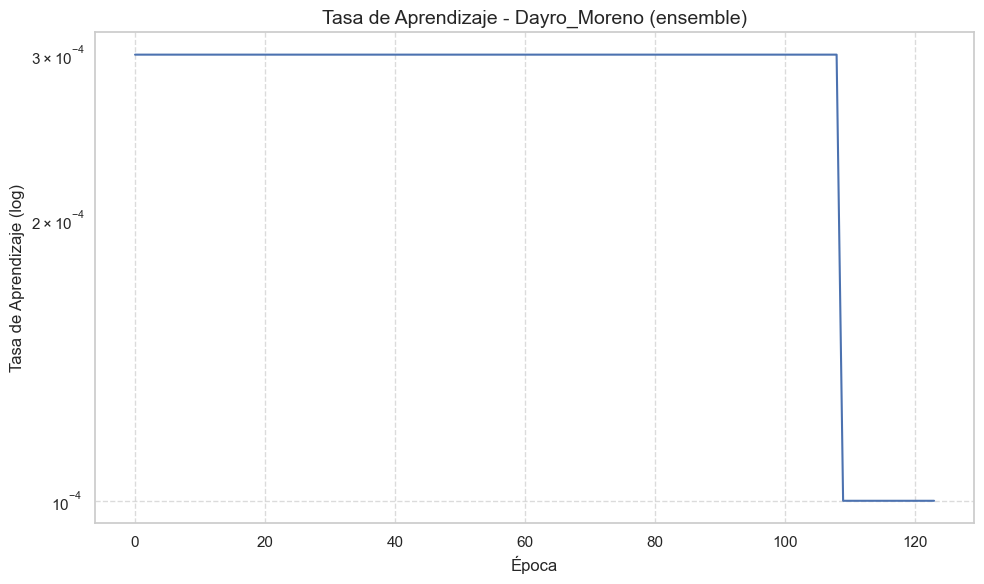

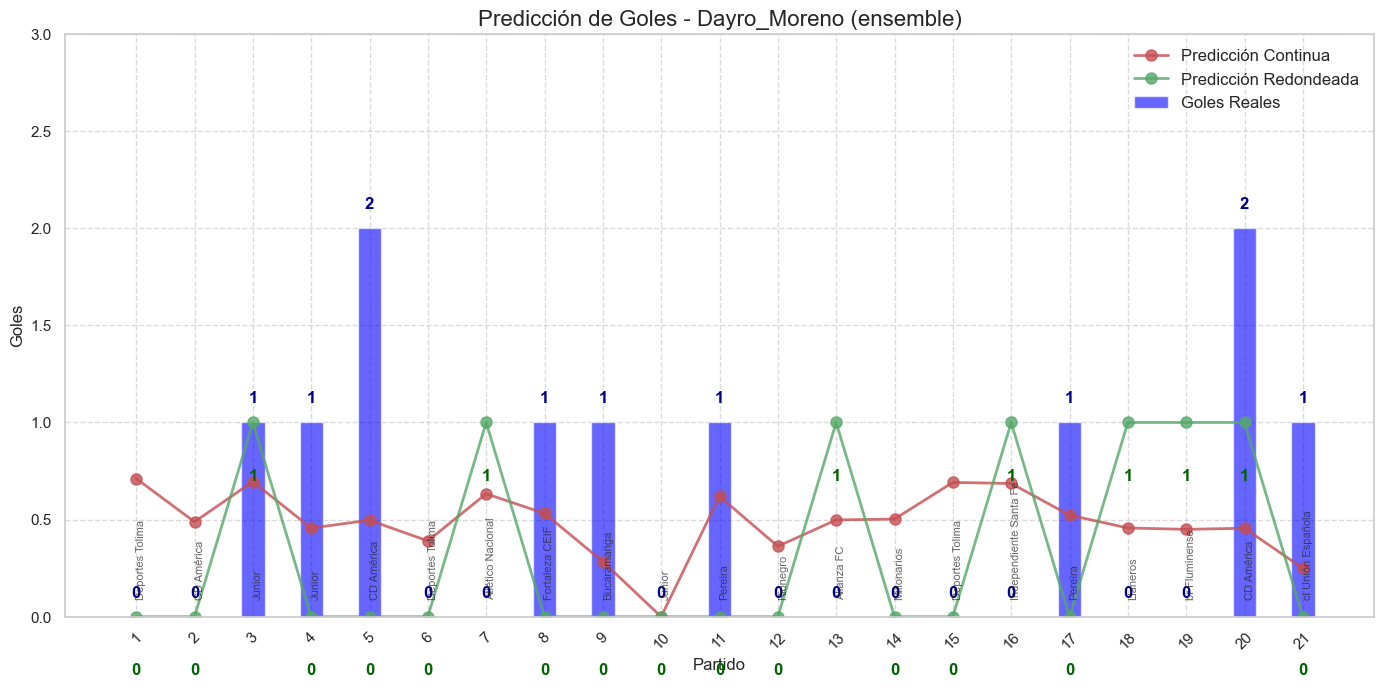

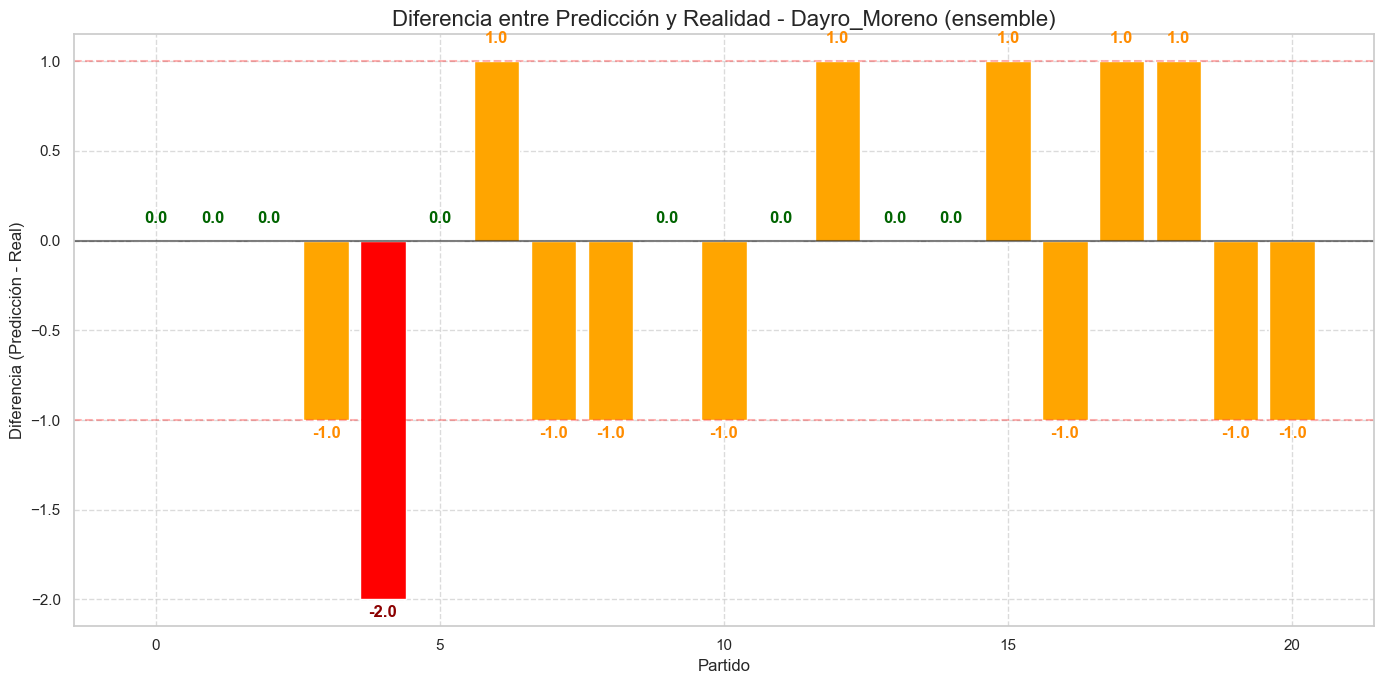

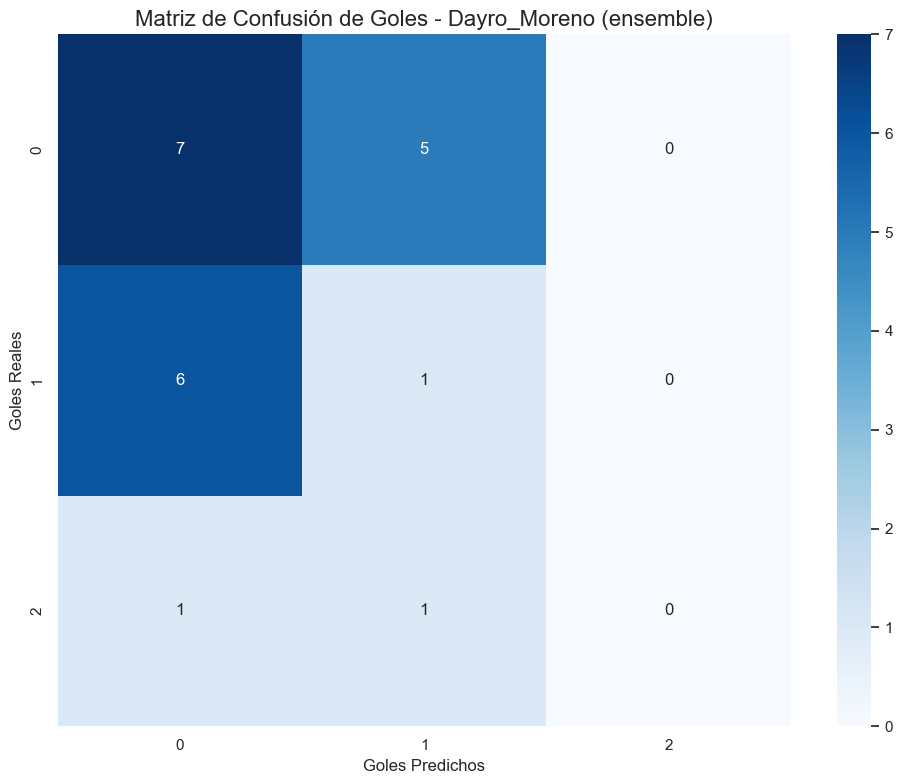


Predicciones para partidos futuros de Dayro_Moreno:
Modelo LSTM (mejor_modelo) cargado para Dayro_Moreno
RMSE: 0.6897
Equipo actual de Dayro_Moreno: Once Caldas
Encontrados 20 partidos futuros para Once Caldas
Característica 'Factor_Oponente' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_5' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Marco_Ultimo_Partido' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Ult_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Tendencia_Robusta' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Es_FinDeSemana' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Racha_Con_Gol' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_7' no en

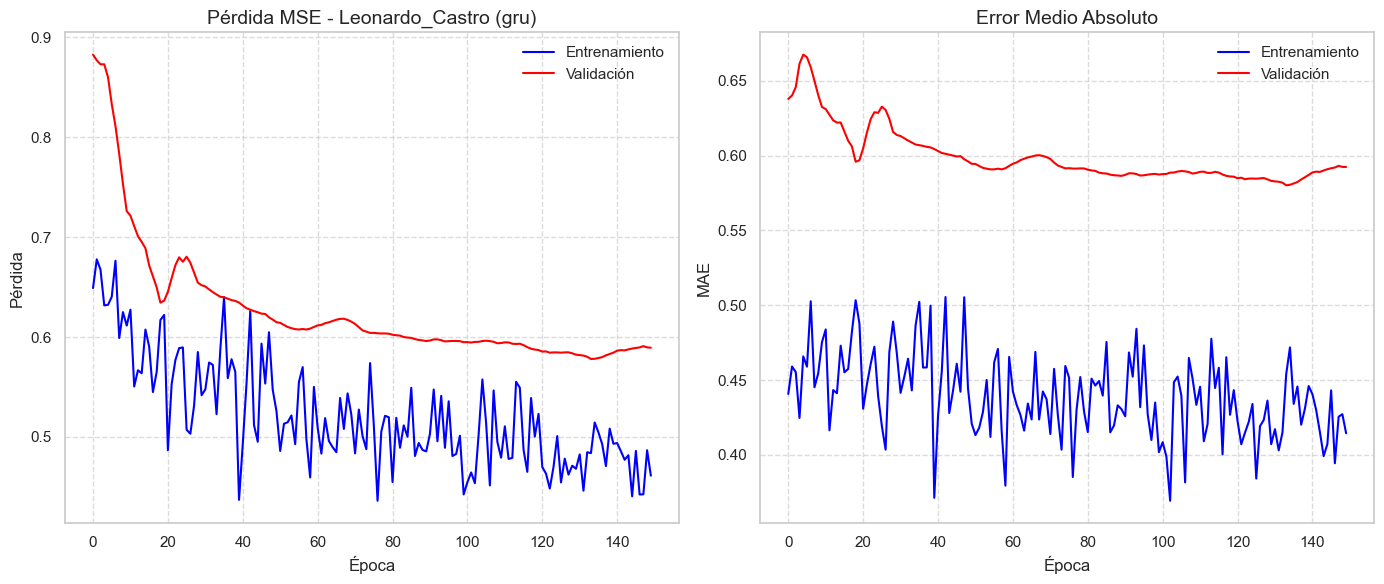

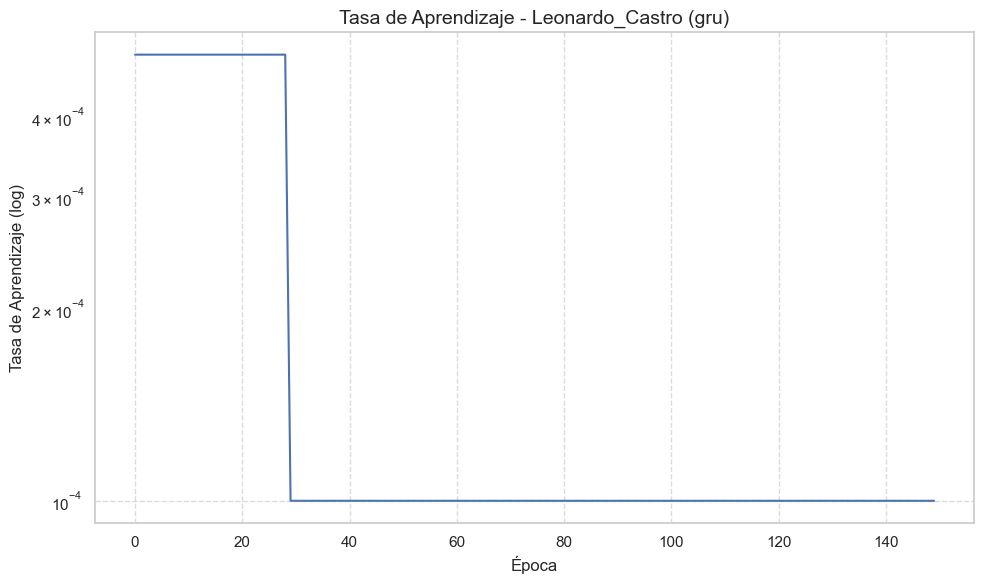

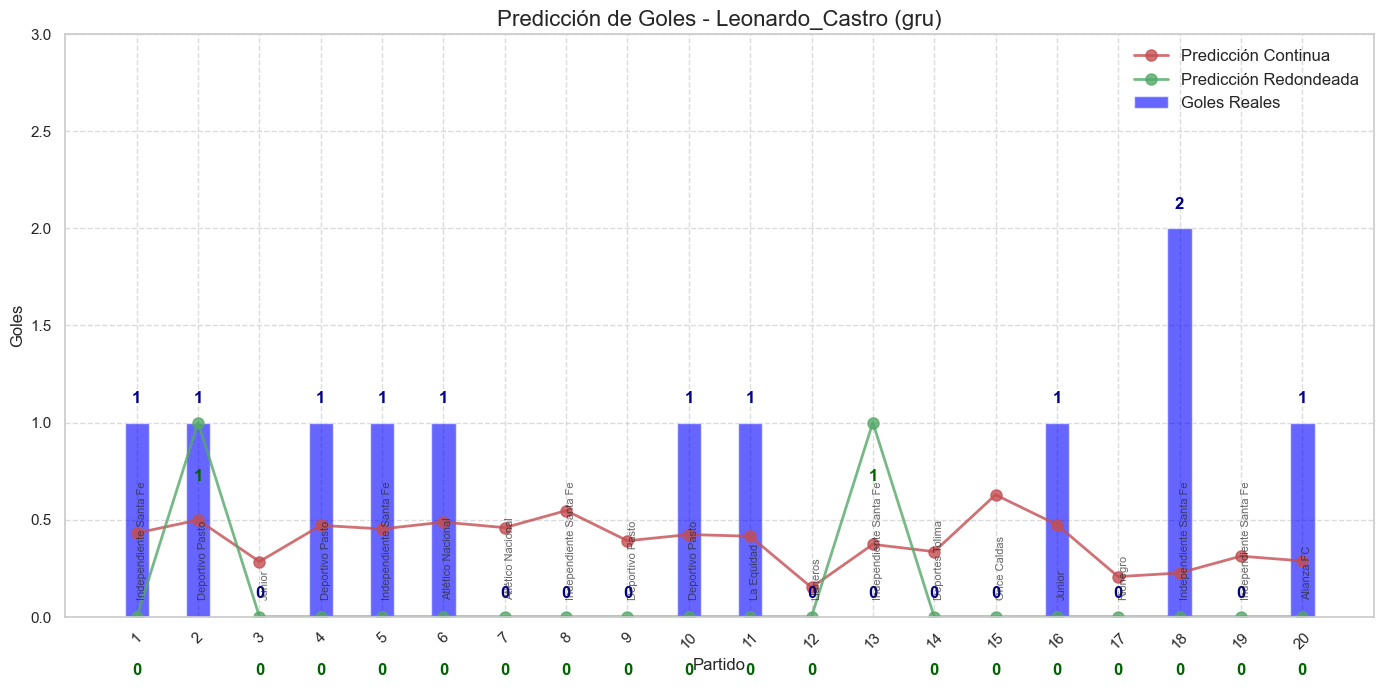

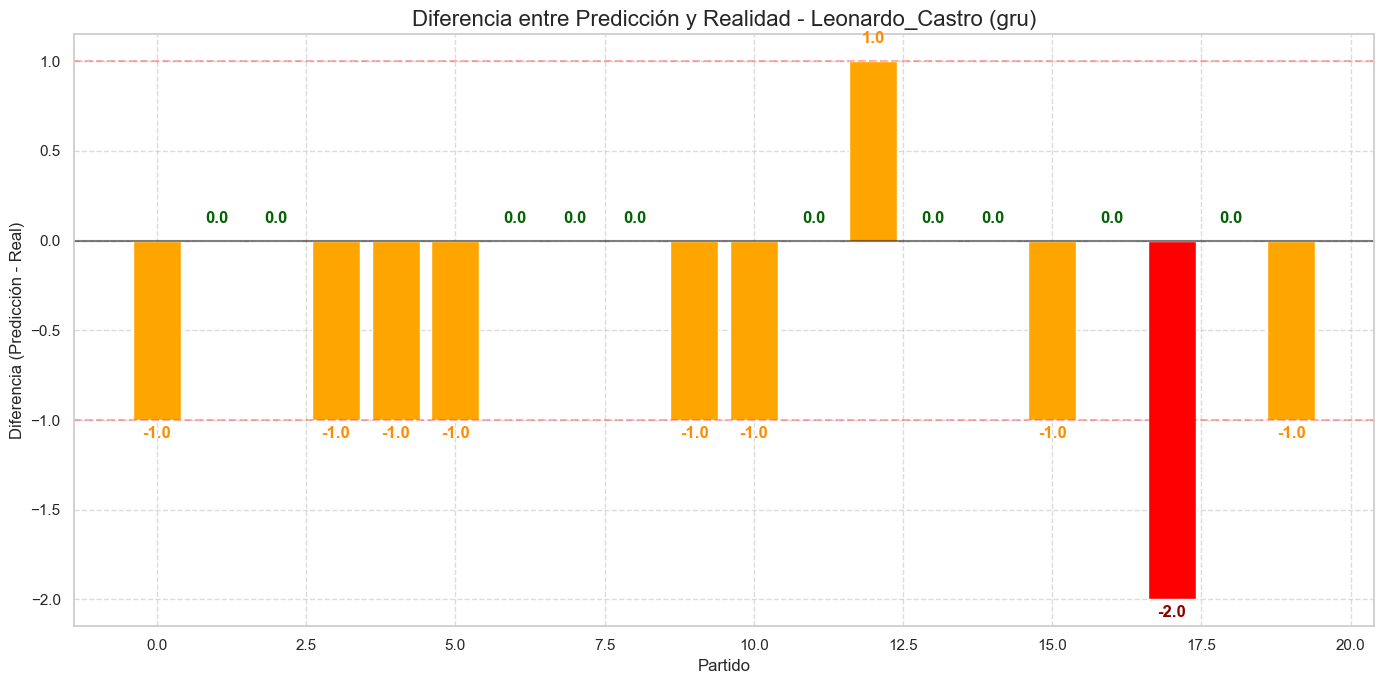

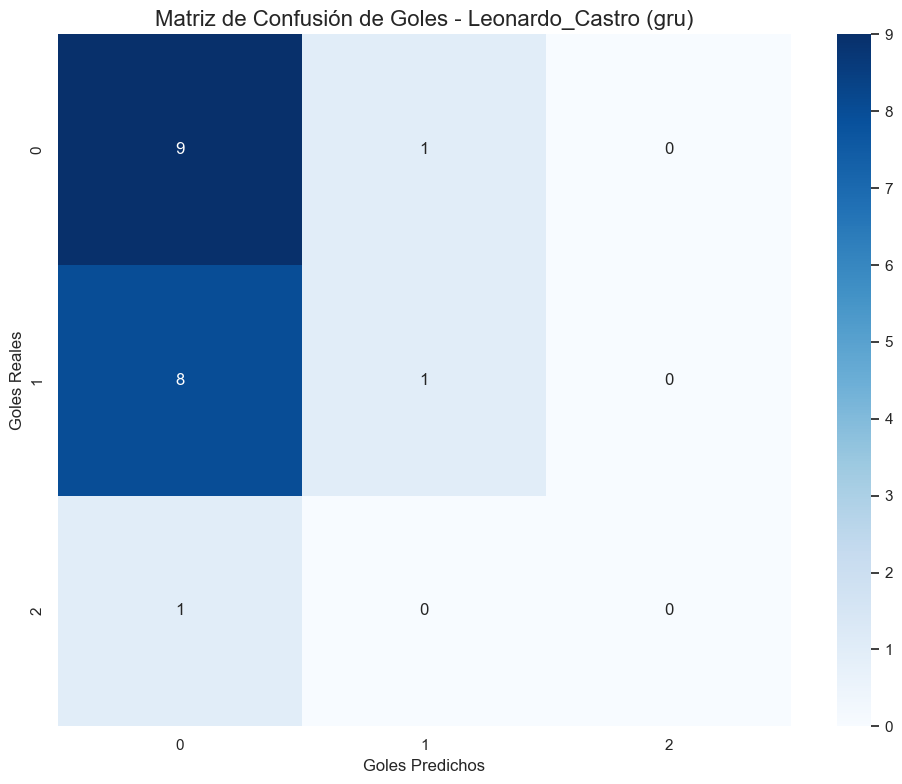


Predicciones para partidos futuros de Leonardo_Castro:
Modelo LSTM (mejor_modelo) cargado para Leonardo_Castro
RMSE: 0.6156
Equipo actual de Leonardo_Castro: Millonarios
Encontrados 20 partidos futuros para Millonarios
Característica 'Factor_Oponente' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_5' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Marco_Ultimo_Partido' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Ult_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Tendencia_Robusta' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Es_FinDeSemana' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Racha_Con_Gol' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom

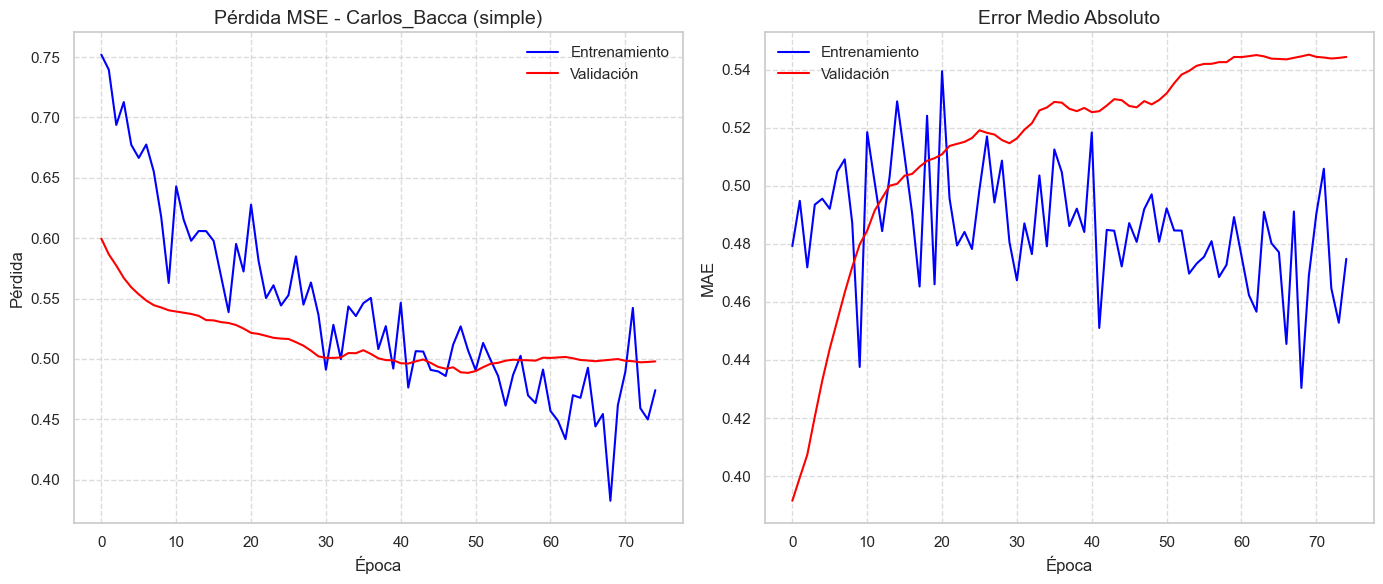

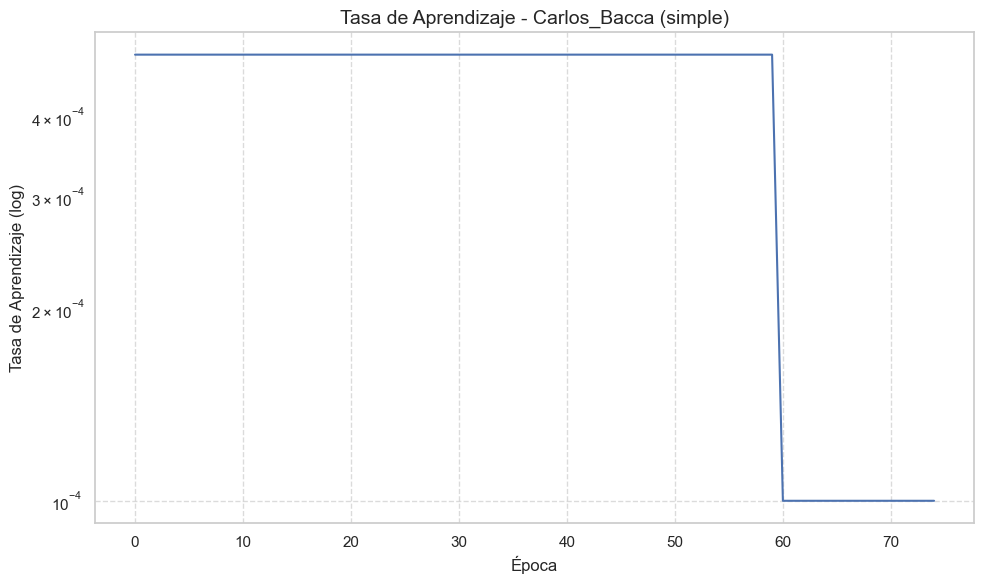

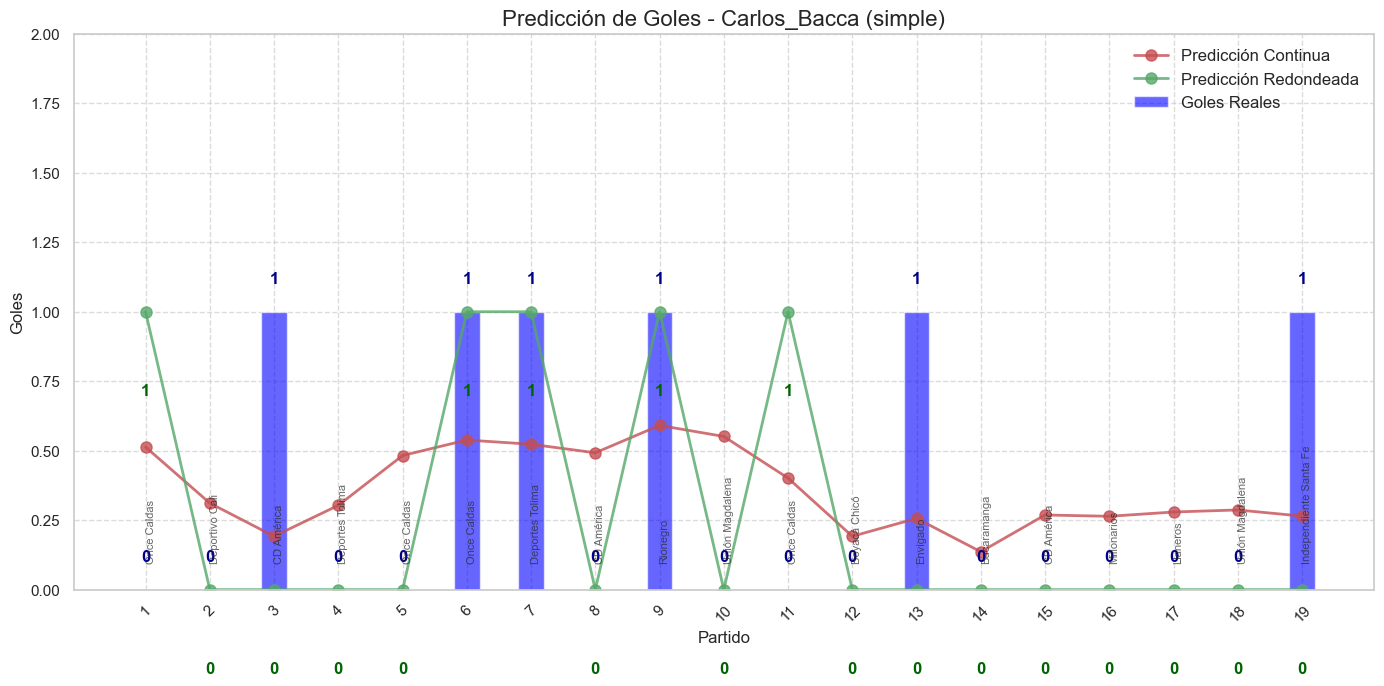

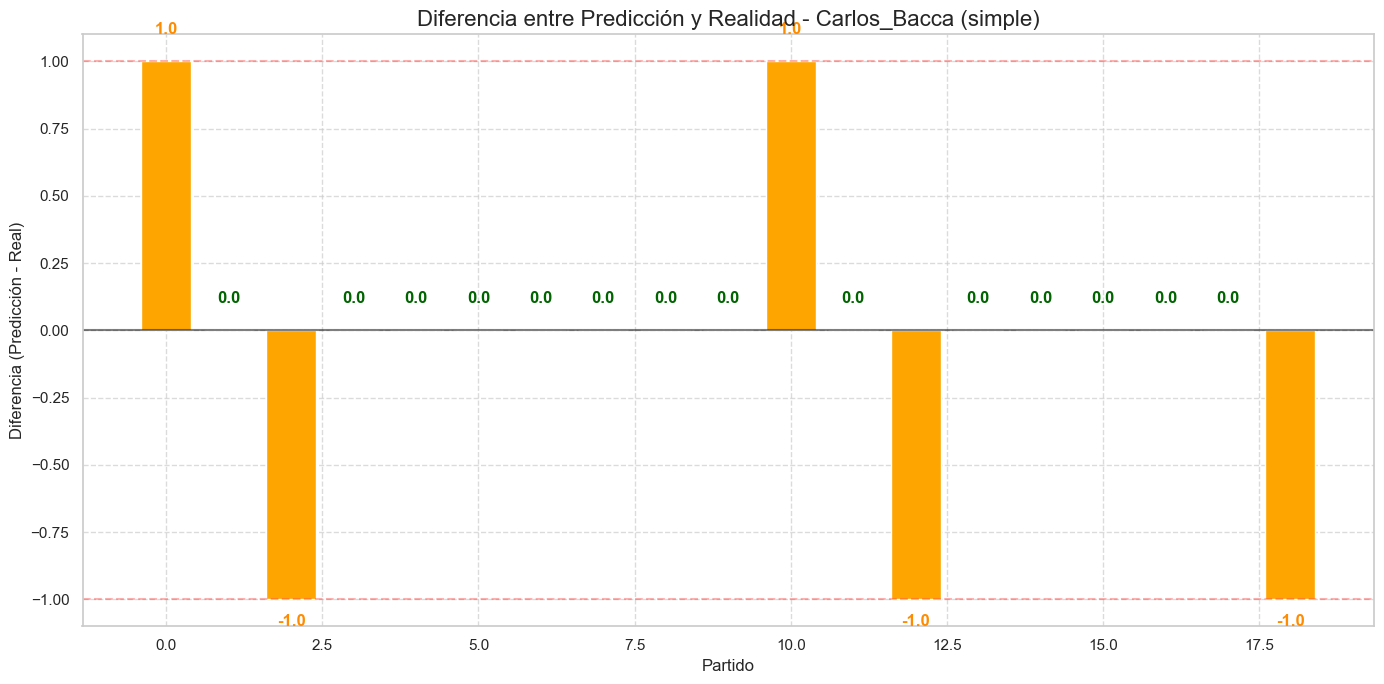

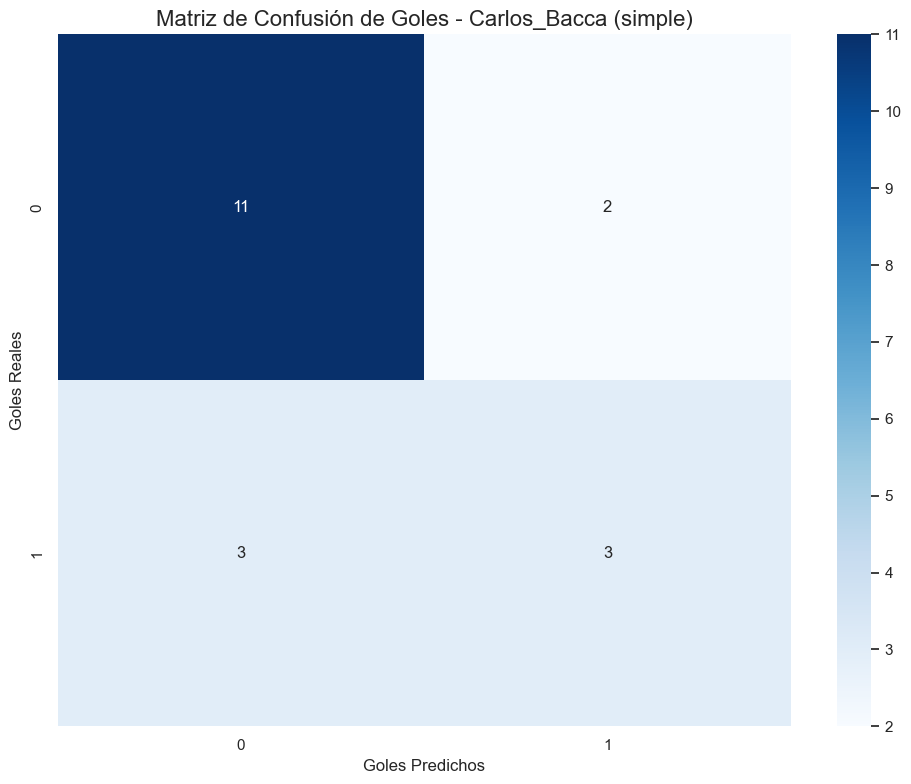


Predicciones para partidos futuros de Carlos_Bacca:
Modelo LSTM (mejor_modelo) cargado para Carlos_Bacca
RMSE: 0.4648
Equipo actual de Carlos_Bacca: Junior
Encontrados 20 partidos futuros para Junior
Característica 'Factor_Oponente' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_5' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Marco_Ultimo_Partido' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Ult_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Tendencia_Robusta' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Es_FinDeSemana' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Racha_Con_Gol' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_7' no encontrada e

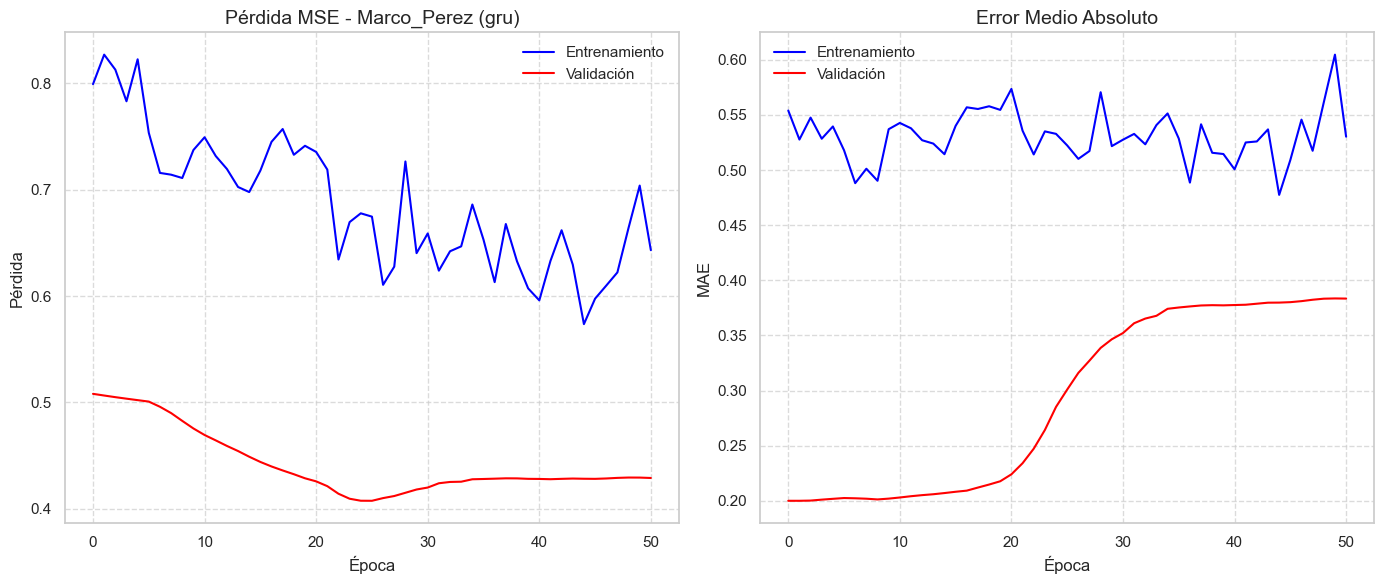

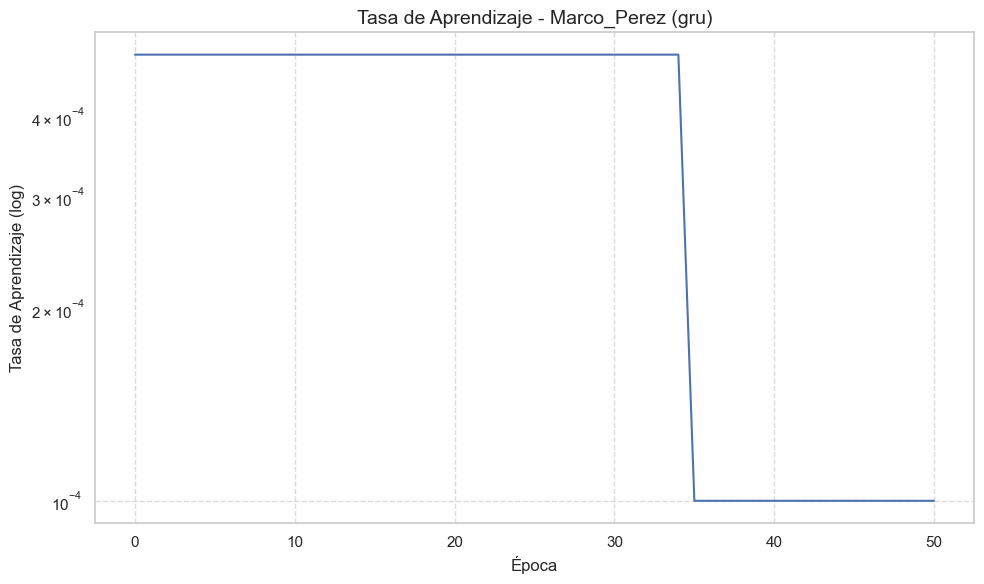

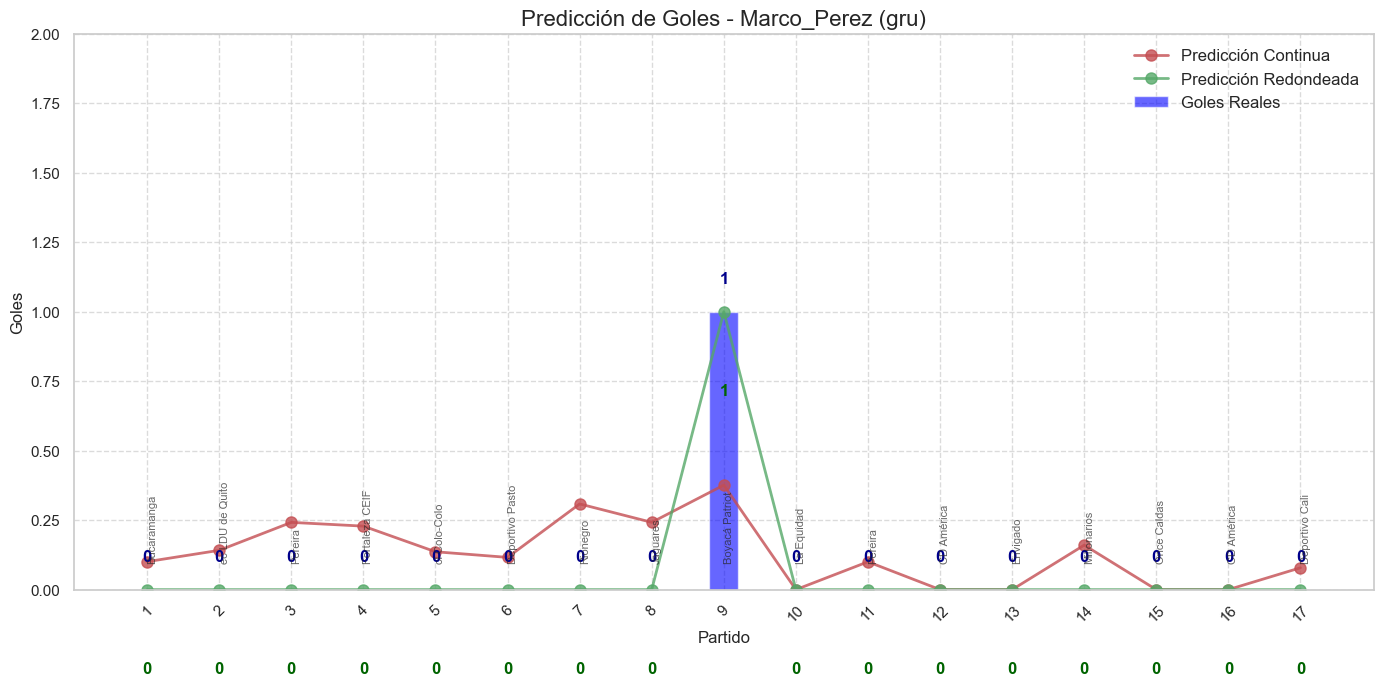

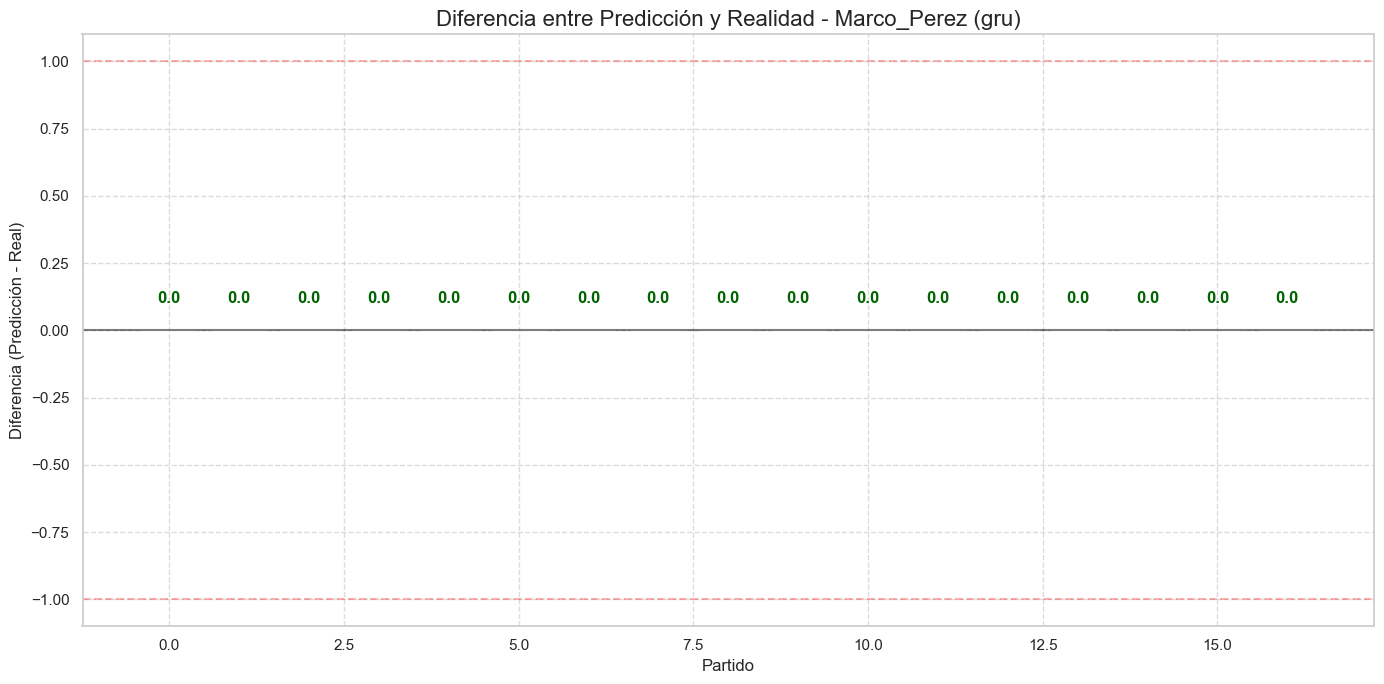

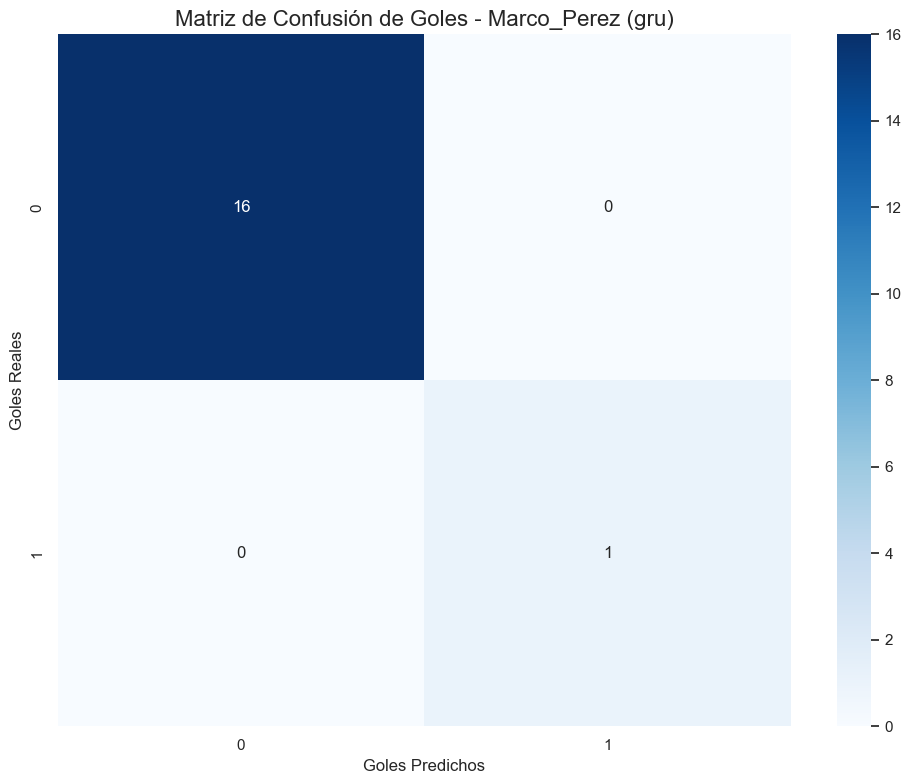


Predicciones para partidos futuros de Marco_Perez:
Modelo LSTM (mejor_modelo) cargado para Marco_Perez
RMSE: 0.2111
Equipo actual de Marco_Perez: Junior
Encontrados 20 partidos futuros para Junior
Característica 'Factor_Oponente' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_5' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Marco_Ultimo_Partido' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Ult_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Tendencia_Robusta' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Es_FinDeSemana' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Racha_Con_Gol' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_7' no encontrada en l

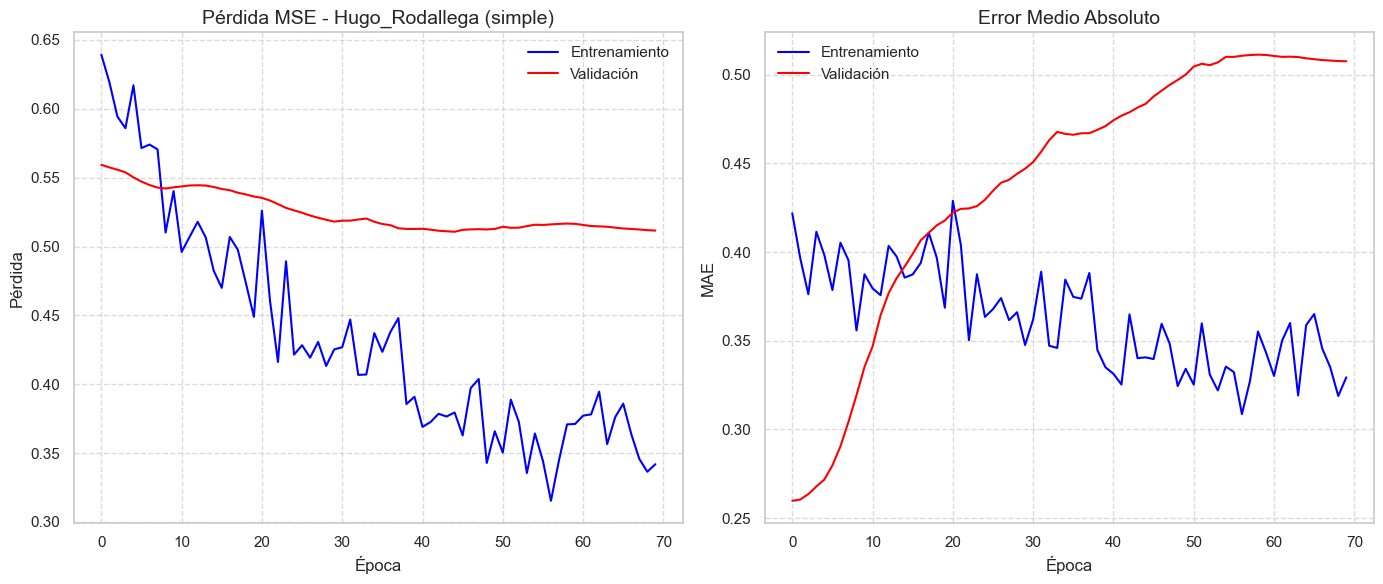

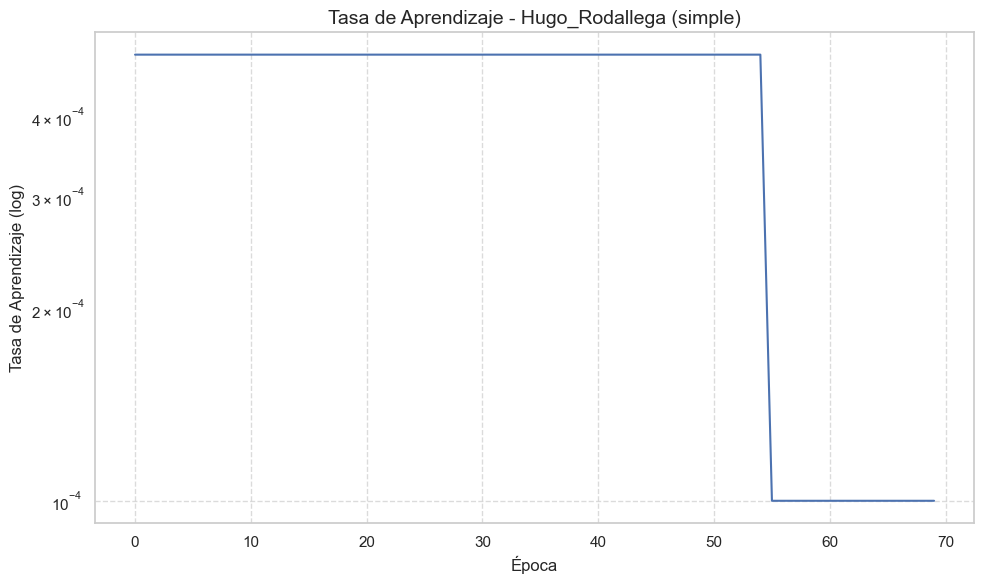

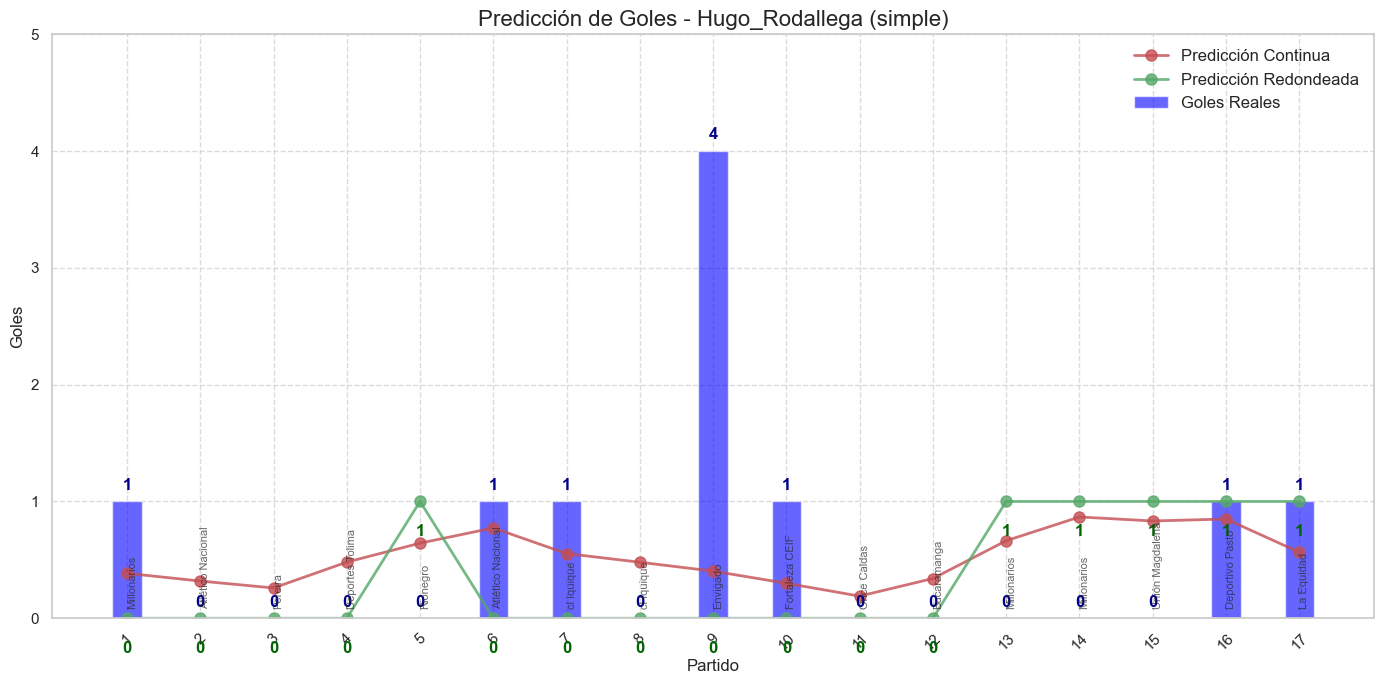

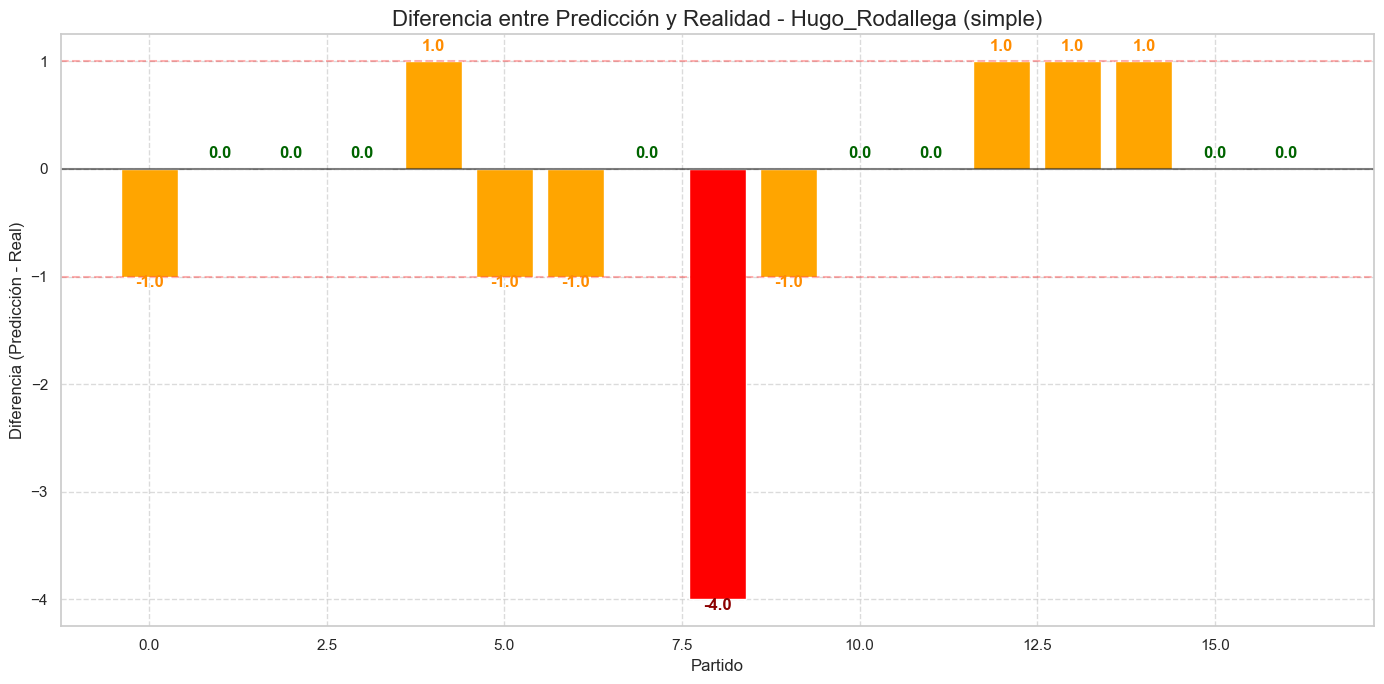

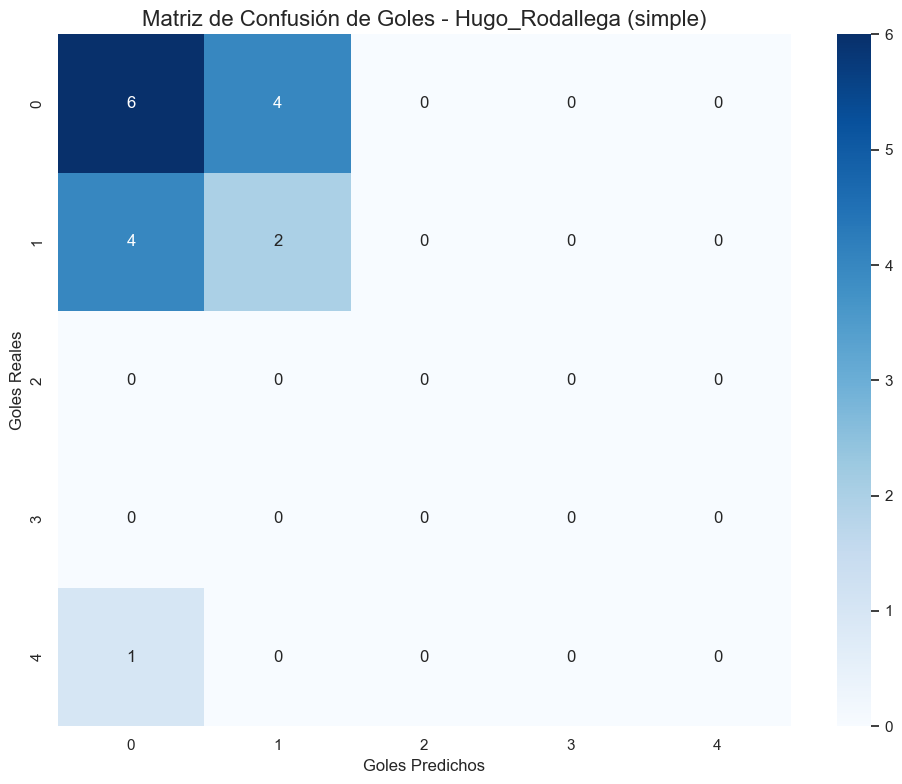


Predicciones para partidos futuros de Hugo_Rodallega:
Modelo LSTM (mejor_modelo) cargado para Hugo_Rodallega
RMSE: 1.0102
Equipo actual de Hugo_Rodallega: Santa Fe
No se encontraron partidos futuros para Santa Fe

=== Comparación de rendimiento entre jugadores ===
                   Modelo  RMSE  MAE  Acierto (%)
Carlos_Bacca       simple  0.46 0.43       100.00
Marco_Perez           gru  0.21 0.15       100.00
Leonardo_Castro       gru  0.62 0.53        95.00
Hugo_Rodallega     simple  1.01 0.66        94.12
Dayro_Moreno     ensemble  0.69 0.60        90.48


<Figure size 1200x600 with 0 Axes>

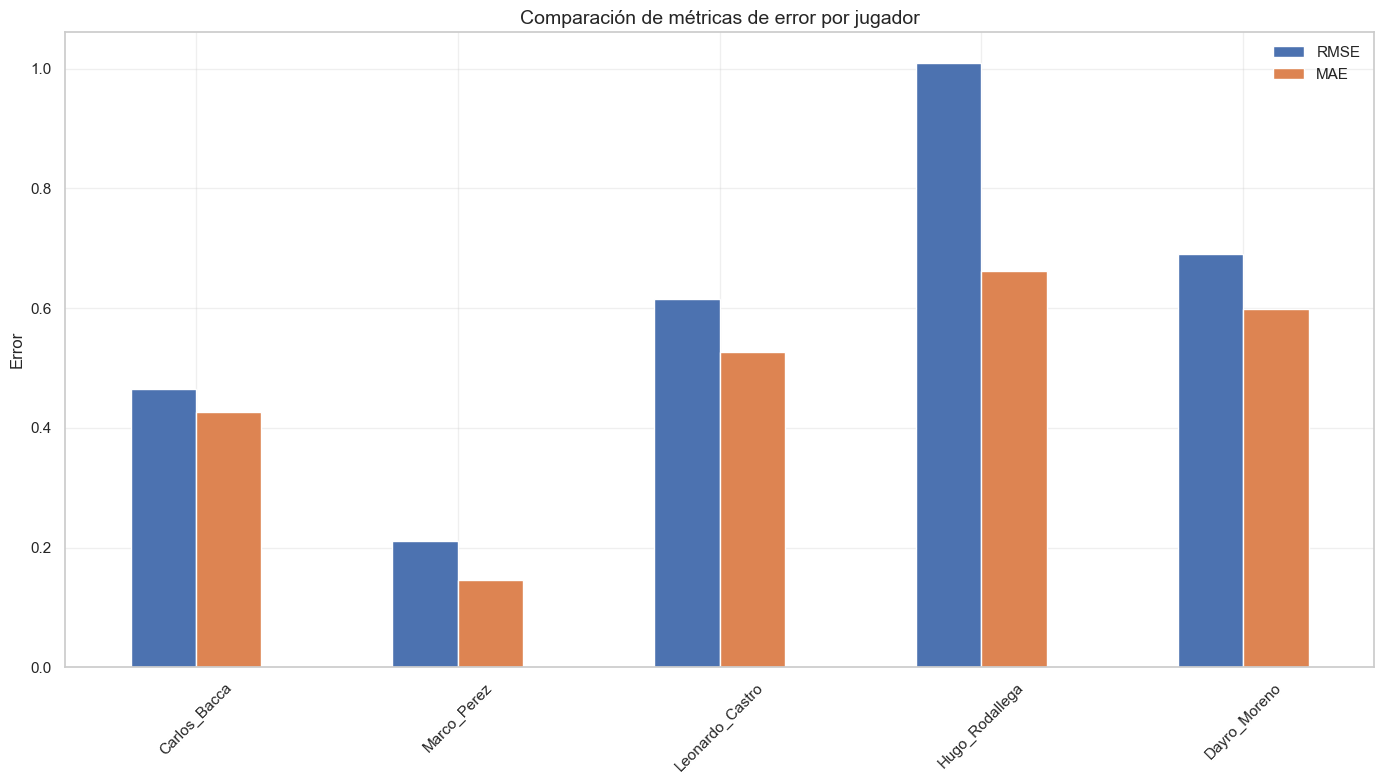

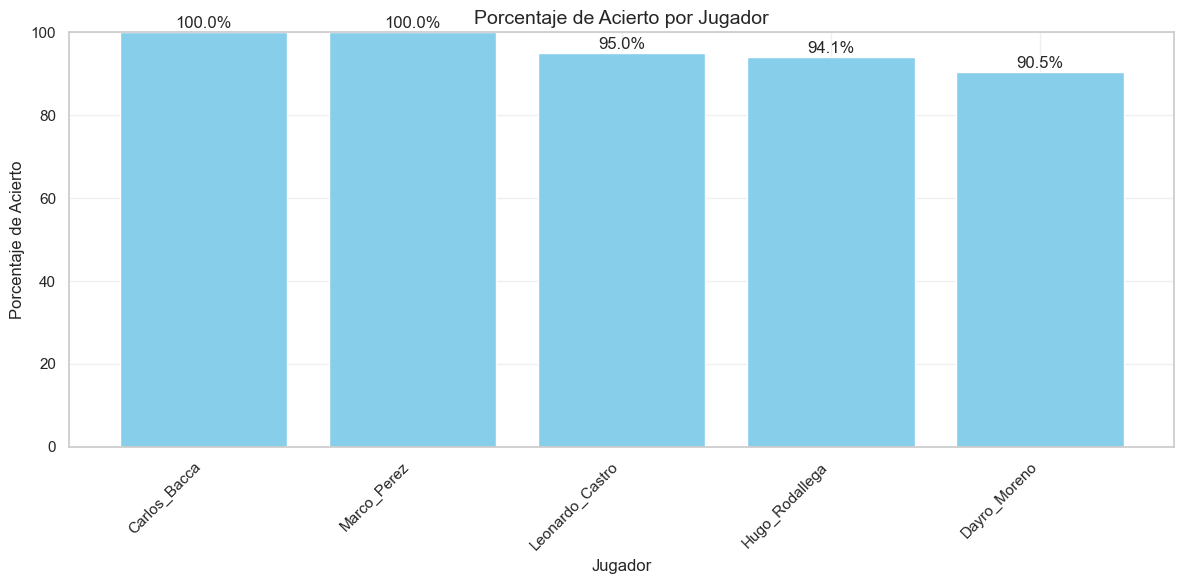

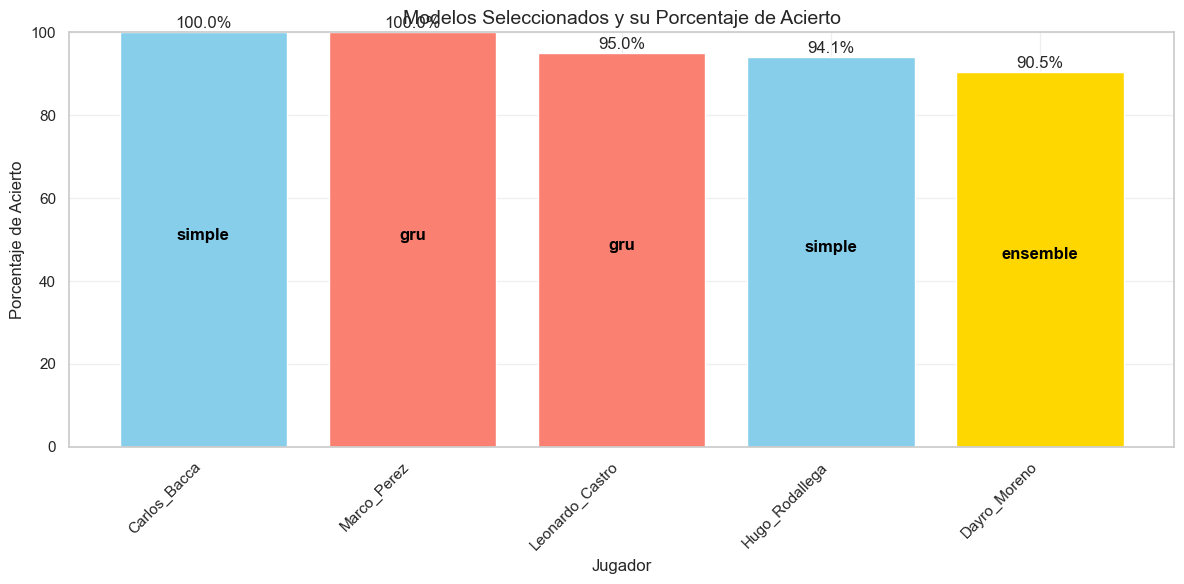


Proceso completo finalizado exitosamente!
Se generaron modelos para 5 jugadores.
Archivos generados:
  - Modelos: carpeta 'modelos_lstm'
  - Predicciones: archivos 'predicciones_[Nombre_Jugador].csv'


In [3]:
# Bloque 1: Importaciones y Configuración
# ===================================================================================

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time
import warnings
import shutil
from datetime import datetime, timedelta

# Para modelos y procesamiento
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Dropout, Input, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
from scipy.stats import poisson

# Configuración de gráficos para Jupyter
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Ignorar advertencias
warnings.filterwarnings('ignore')

# Configurar semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Crear directorio para modelos si no existe
if not os.path.exists('modelos_lstm'):
    os.makedirs('modelos_lstm')
    print("Directorio 'modelos_lstm' creado correctamente.")

print("Configuración inicial completada.")

# Bloque 2: Funciones de Procesamiento de Datos
# ===================================================================================

def calcular_porcentaje_acierto(y_true, y_pred):
    """
    Calcula el porcentaje de acierto (diferencia menor a 1 gol)
    """
    aciertos = np.sum(np.abs(y_true - np.array(y_pred)) < 1)
    return (aciertos / len(y_true)) * 100

def estandarizar_nombre_equipo(nombre):
    """
    Estandariza nombres de equipos para coincidir con los datos históricos.
    """
    mapeo_equipos = {
        'Atlético Junior': 'Junior',
        'Junior': 'Junior',
        'Nacional': 'Atlético Nacional',
        'Atlético Nacional': 'Atlético Nacional',
        'Deportivo Pereira': 'Pereira',
        'Pereira': 'Pereira',
        'Atlético Bucaramanga': 'Bucaramanga',
        'Bucaramanga': 'Bucaramanga',
        'Santa Fe': 'Independiente Santa Fe',
        'Independiente Santa Fe': 'Independiente Santa Fe',
        'Cali': 'Deportivo Cali',
        'Deportivo Cali': 'Deportivo Cali',
        'América': 'América de Cali',
        'América de Cali': 'América de Cali',
        'Millonarios': 'Millonarios',
        'Once Caldas': 'Once Caldas',
        'Águilas Doradas': 'Rionegro',
        'La Equidad': 'La Equidad',
        'Envigado': 'Envigado',
        'Fortaleza': 'Fortaleza CEIF',
        'Unión Magdalena': 'Unión Magdalena',
        'Pasto': 'Deportivo Pasto',
        'Deportivo Pasto': 'Deportivo Pasto',
        'Tolima': 'Deportes Tolima',
        'Deportes Tolima': 'Deportes Tolima',
        'Alianza': 'Alianza FC',
        'Medellín': 'Independiente Medellín',
        'Chicó': 'Boyacá Chicó',
        'Boyacá Chicó': 'Boyacá Chicó',
        'Llaneros': 'Llaneros'
    }
    
    return mapeo_equipos.get(nombre, nombre)

def procesar_calendario(ruta_archivo):
    """
    Procesa el archivo de calendario convirtiéndolo en un DataFrame estructurado.
    """
    try:
        with open(ruta_archivo, 'r', encoding='utf-8') as file:
            texto = file.read()
        
        partidos = []
        fecha_actual = None
        fecha_numero = None
        
        lineas = texto.split('\n')
        i = 0
        
        while i < len(lineas):
            linea = lineas[i].strip()
            
            # Detectar inicio de una nueva fecha
            if linea.startswith('Fecha'):
                partes = linea.split()
                if len(partes) >= 2:
                    fecha_numero = int(partes[1])
                    
                    # Buscar la línea de fecha
                    i += 1
                    if i < len(lineas):
                        fecha_texto = lineas[i].strip()
                        
                        # Extraer mes y día
                        meses = {
                            'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4,
                            'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8,
                            'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
                        }
                        
                        # Extraer fecha
                        try:
                            partes_fecha = fecha_texto.split()
                            dia = int(partes_fecha[1])
                            mes = meses.get(partes_fecha[3].lower(), 1)
                            fecha_actual = datetime(2025, mes, dia)
                        except (ValueError, IndexError):
                            fecha_actual = None
            
            # Detectar partido
            elif linea.startswith('-'):
                equipos = linea[1:].split(' vs. ')
                if len(equipos) == 2:
                    local = equipos[0].strip()
                    visitante = equipos[1].strip()
                    
                    # Estandarizar nombres de equipos
                    local_std = estandarizar_nombre_equipo(local)
                    visitante_std = estandarizar_nombre_equipo(visitante)
                    
                    partidos.append({
                        'Fecha_Numero': fecha_numero,
                        'Fecha': fecha_actual,
                        'Local': local_std,
                        'Visitante': visitante_std
                    })
            
            i += 1
        
        # Convertir a DataFrame
        df_calendario = pd.DataFrame(partidos)
        
        return df_calendario
    except Exception as e:
        print(f"Error al procesar calendario: {str(e)}")
        return pd.DataFrame()

def calcular_tendencia_robusta(serie, ventanas=[3, 5, 7]):
    """
    Calcula la tendencia de una serie de forma más robusta usando múltiples ventanas temporales.
    """
    tendencias = pd.Series(0, index=serie.index)
    pesos = {3: 0.5, 5: 0.3, 7: 0.2}  # Pesos para diferentes ventanas
    
    for ventana in ventanas:
        if len(serie) >= ventana:
            for i in range(ventana, len(serie) + 1):
                try:
                    # Obtener datos de la ventana actual
                    datos_ventana = serie.iloc[i-ventana:i].values
                    x = np.arange(ventana)
                    # Regresión lineal para calcular la pendiente
                    slope, _, _, _, _ = stats.linregress(x, datos_ventana)
                    idx = serie.index[i-1]
                    tendencias.loc[idx] += slope * pesos[ventana]
                except:
                    pass
    
    return tendencias

def calcular_factores_oponente(df_jugador, equipos_similares=None):
    """
    Calcula factores avanzados para oponentes, incluyendo rendimiento histórico
    y similitud entre equipos.
    """
    # Inicializar factor básico
    df_jugador['Factor_Oponente'] = 1.0
    
    # Calcular el factor tradicional basado en historial directo
    oponentes_unicos = df_jugador['Oponente_Estandarizado'].unique()
    for oponente in oponentes_unicos:
        df_oponente = df_jugador[df_jugador['Oponente_Estandarizado'] == oponente].copy()
        
        for idx, row in df_oponente.iterrows():
            fecha_actual = row['Fecha']
            # Historial directo contra este oponente
            hist_directo = df_oponente[(df_oponente['Fecha'] < fecha_actual)]
            
            factor = 1.0
            if len(hist_directo) > 0:
                promedio_vs_oponente = hist_directo['Goles'].mean()
                # Normalizar para crear un factor multiplicativo
                factor = (promedio_vs_oponente + 1) / (df_jugador['Goles'].mean() + 1) if df_jugador['Goles'].mean() > 0 else 1.0
                
                # Dar más peso a partidos recientes (últimos 3)
                hist_reciente = hist_directo.sort_values('Fecha').tail(3)
                if len(hist_reciente) > 0:
                    factor_reciente = (hist_reciente['Goles'].mean() + 1) / (df_jugador['Goles'].mean() + 1) if df_jugador['Goles'].mean() > 0 else 1.0
                    # Combinar factor histórico (peso 0.7) y reciente (peso 0.3)
                    factor = 0.7 * factor + 0.3 * factor_reciente
            
            df_jugador.loc[idx, 'Factor_Oponente'] = factor
    
    return df_jugador

def obtener_perfil_jugador(df_jugador):
    """
    Obtiene el perfil estadístico de un jugador para entender sus patrones.
    """
    # Calcular estadísticas generales
    perfil = {
        'goles_promedio': df_jugador['Goles'].mean(),
        'goles_std': df_jugador['Goles'].std(),
        'goles_max': df_jugador['Goles'].max(),
        'porcentaje_partidos_con_gol': (df_jugador['Goles'] > 0).mean() * 100,
        'rendimiento_local': df_jugador[df_jugador['Sede_Local'] == 1]['Goles'].mean() if 'Sede_Local' in df_jugador.columns else 0,
        'rendimiento_visitante': df_jugador[df_jugador['Sede_Visitante'] == 1]['Goles'].mean() if 'Sede_Visitante' in df_jugador.columns else 0,
        'ratio_local_visitante': 1.0,  # Valor por defecto
        'tiros_totales_promedio': df_jugador['Tiros_totales'].mean() if 'Tiros_totales' in df_jugador.columns else df_jugador['Tiros totales'].mean() if 'Tiros totales' in df_jugador.columns else 0,
        'tiros_puerta_promedio': df_jugador['Tiros_a_puerta'].mean() if 'Tiros_a_puerta' in df_jugador.columns else df_jugador['Tiros a puerta'].mean() if 'Tiros a puerta' in df_jugador.columns else 0
    }
    
    # Calcular ratio local/visitante si ambos tienen partidos
    if perfil['rendimiento_visitante'] > 0:
        perfil['ratio_local_visitante'] = perfil['rendimiento_local'] / perfil['rendimiento_visitante']
    
    return perfil

def crear_secuencias(df, caracteristicas, ventana=3, include_labels=True):
    """
    Crea secuencias para el modelo LSTM.
    """
    if df.empty:
        return np.array([]), np.array([]), [], []
    
    X, y, fechas, oponentes = [], [], [], []
    
    # Si solo necesitamos X para predecir (sin etiquetas)
    if not include_labels:
        # Usar los últimos 'ventana' registros
        if len(df) >= ventana:
            ultimos_datos = df.iloc[-ventana:][caracteristicas].values
            X.append(ultimos_datos)
            fechas.append(df.iloc[-1]['Fecha'])
            oponentes.append(df.iloc[-1]['Oponente_Estandarizado'])
    else:
        # Crear secuencias para entrenamiento/validación
        for i in range(ventana, len(df)):
            # Secuencia de ventana partidos anteriores
            X.append(df.iloc[i-ventana:i][caracteristicas].values)
            
            # Variable objetivo: Número exacto de goles
            y.append(df.iloc[i]['Goles'])
            
            # Información adicional para análisis
            fechas.append(df.iloc[i]['Fecha'])
            oponentes.append(df.iloc[i]['Oponente_Estandarizado'])
    
    return np.array(X), np.array(y), fechas, oponentes

def preparar_datos_lstm_mejorado(df_original, jugador_id, test_size=0.2, min_partidos=20):
    """
    Prepara características para el modelo LSTM con mejoras en las características.
    
    Args:
        df_original: DataFrame con datos históricos
        jugador_id: Nombre del jugador
        test_size: Proporción de datos para prueba
        min_partidos: Número mínimo de partidos necesarios para entrenar
        
    Returns:
        Tupla con datos completos, entrenamiento, prueba y características
    """
    print(f"\n--- Preparando datos para {jugador_id} ---")
    
    # Filtrar datos para el jugador y ordenar cronológicamente
    df_jugador = df_original[df_original['Jugador'] == jugador_id].copy().sort_values('Fecha')
    
    # Filtro para todos los jugadores desde 2022 si tienen suficientes partidos
    fecha_inicio = pd.Timestamp('2022-01-01')
    df_jugador_desde_2022 = df_jugador[df_jugador['Fecha'] >= fecha_inicio]
    
    # Verificar cantidad mínima de datos
    if len(df_jugador_desde_2022) >= min_partidos:
        print(f"Usando datos de {jugador_id} desde {fecha_inicio.strftime('%d/%m/%Y')} - {len(df_jugador_desde_2022)} partidos")
        df_jugador = df_jugador_desde_2022
    else:
        print(f"⚠️ Datos insuficientes desde 2022 para {jugador_id}: solo {len(df_jugador_desde_2022)} partidos.")
        # Si hay pocos datos desde 2022, intentamos usar todos los disponibles
        if len(df_jugador) < min_partidos:
            print(f"❌ Aún insuficientes: {len(df_jugador)} partidos en total. Se necesitan al menos {min_partidos}.")
            return None, None, None, None, None
        else:
            print(f"Usando todos los datos disponibles: {len(df_jugador)} partidos")
    
    if df_jugador.empty:
        print(f"No hay datos disponibles para {jugador_id}")
        return None, None, None, None, None
    
    # Renombrar columnas con espacios
    rename_dict = {}
    for col in df_jugador.columns:
        if ' ' in col:
            new_name = col.replace(' ', '_')
            rename_dict[col] = new_name
    
    if rename_dict:
        df_jugador = df_jugador.rename(columns=rename_dict)
    
    # Obtener perfil estadístico del jugador
    perfil_jugador = obtener_perfil_jugador(df_jugador)
    print(f"Perfil estadístico de {jugador_id}:")
    for key, value in perfil_jugador.items():
        print(f"  - {key}: {value:.2f}")
    
    # ===== CARACTERÍSTICAS MEJORADAS =====
    
    # 1. Promedios móviles de goles (más ventanas)
    try:
        for ventana in [3, 5, 7, 10]:
            if len(df_jugador) >= ventana:
                col_name = f'Goles_Prom_{ventana}'
                df_jugador[col_name] = df_jugador['Goles'].rolling(window=ventana, min_periods=1).mean()
    except Exception as e:
        print(f"Error al calcular promedios móviles: {str(e)}")
        # Asegurarse de que las columnas existan
        df_jugador['Goles_Prom_3'] = df_jugador['Goles'].rolling(window=3, min_periods=1).mean()
        df_jugador['Goles_Prom_5'] = df_jugador['Goles'].rolling(window=5, min_periods=1).mean()
    
    # 2. Cálculo de factores de oponente mejorados
    try:
        df_jugador = calcular_factores_oponente(df_jugador)
    except Exception as e:
        print(f"Error al calcular Factor_Oponente: {str(e)}")
        # Asegurarse de que la columna exista
        df_jugador['Factor_Oponente'] = 1.0
    
    # 3. Tendencia robusta (usa múltiples ventanas)
    try:
        df_jugador['Tendencia_Robusta'] = calcular_tendencia_robusta(df_jugador['Goles'])
    except Exception as e:
        print(f"Error al calcular Tendencia_Robusta: {str(e)}")
        df_jugador['Tendencia_Robusta'] = 0
    
    # 4. Variables para marcar partidos recientes
    try:
        df_jugador['Marco_Ultimo_Partido'] = df_jugador['Goles'].shift(1).fillna(0)
        df_jugador['Goles_Ult_3'] = df_jugador['Goles'].rolling(window=3, min_periods=1).sum()
        df_jugador['Goles_Ult_5'] = df_jugador['Goles'].rolling(window=5, min_periods=1).sum()
        
        # Secuencias de partidos con/sin gol
        goles_binario = (df_jugador['Goles'] > 0).astype(int)
        df_jugador['Racha_Con_Gol'] = goles_binario.groupby((goles_binario != goles_binario.shift()).cumsum()).cumcount()
        
        # Goles contra oponentes fuertes/débiles
        if 'Indice_Ofensivo' in df_jugador.columns:
            # Oponentes con alto índice ofensivo
            alto_indice = df_jugador['Indice_Ofensivo'] > df_jugador['Indice_Ofensivo'].median()
            df_jugador['Goles_vs_Fuertes'] = df_jugador.loc[alto_indice, 'Goles'].rolling(window=5, min_periods=1).mean().reindex(df_jugador.index).fillna(0)
    except Exception as e:
        print(f"Error al calcular variables de partidos recientes: {str(e)}")
        # Asegurarse de que las columnas existan
        df_jugador['Marco_Ultimo_Partido'] = 0
        df_jugador['Goles_Ult_3'] = 0
        df_jugador['Racha_Con_Gol'] = 0
    
    # 5. Factores de contexto y temporada
    try:
        # Día de la semana
        if 'Día_de_la_semana' in df_jugador.columns:
            day_mapping = {
                'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
                'Friday': 4, 'Saturday': 5, 'Sunday': 6,
                'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3,
                'Viernes': 4, 'Sábado': 5, 'Domingo': 6
            }
            df_jugador['Dia_Num'] = df_jugador['Día_de_la_semana'].map(day_mapping)
            
            # Días de fin de semana como factor
            df_jugador['Es_FinDeSemana'] = df_jugador['Dia_Num'].apply(lambda x: 1 if x >= 4 else 0)
        
        # Rendimiento por temporada
        if 'Temporada' in df_jugador.columns:
            temporadas = df_jugador['Temporada'].unique()
            for temp in temporadas:
                temp_data = df_jugador[df_jugador['Temporada'] == temp]
                avg_goles = temp_data['Goles'].mean()
                df_jugador.loc[df_jugador['Temporada'] == temp, 'Rendimiento_Temporada'] = avg_goles
        
        # Eficiencia y Precisión
        if 'Tiros_totales' in df_jugador.columns and 'Tiros_a_puerta' in df_jugador.columns:
            # Calcular eficiencia en ventana móvil
            df_jugador['Tiros_totales_5'] = df_jugador['Tiros_totales'].rolling(window=5, min_periods=1).sum()
            df_jugador['Goles_5'] = df_jugador['Goles'].rolling(window=5, min_periods=1).sum()
            
            # Evitar divisiones por cero
            mascara = df_jugador['Tiros_totales_5'] > 0
            df_jugador.loc[mascara, 'Eficiencia_5'] = df_jugador.loc[mascara, 'Goles_5'] / df_jugador.loc[mascara, 'Tiros_totales_5']
            df_jugador.loc[~mascara, 'Eficiencia_5'] = 0
    except Exception as e:
        print(f"Error al calcular factores de contexto: {str(e)}")
        # Asegurarse de que las columnas existan
        df_jugador['Es_FinDeSemana'] = 0
        df_jugador['Rendimiento_Temporada'] = df_jugador['Goles'].mean()
    
    # Llenar NaNs con 0
    df_jugador = df_jugador.fillna(0)
    
    # Seleccionar características clave basadas en el análisis mejorado
    caracteristicas_clave = [
        'Tiros_a_puerta', 'Tiros_totales', 'Minutos',
        'Sede_Local', 'Sede_Visitante',
        'Factor_Oponente', 'Goles_Prom_3', 'Goles_Prom_5',
        'Marco_Ultimo_Partido', 'Goles_Ult_3', 'Tendencia_Robusta',
        'Es_FinDeSemana', 'Racha_Con_Gol', 'Goles_Prom_7'
    ]
    
    # Añadir características adicionales si existen
    caracteristicas_opcionales = [
        'Eficiencia_5', 'Goles_vs_Fuertes', 'Rendimiento_Temporada', 
        'Goles_Prom_10', 'Goles_Ult_5'
    ]
    
    for feat in caracteristicas_opcionales:
        if feat in df_jugador.columns:
            caracteristicas_clave.append(feat)
    
    # Asegurarse de que todas las características existan en el DataFrame
    for feature in caracteristicas_clave:
        if feature not in df_jugador.columns:
            print(f"Característica '{feature}' no encontrada, creando con valor predeterminado 0")
            df_jugador[feature] = 0.0
    
    # Filtrar solo las características que existen
    caracteristicas_disponibles = [c for c in caracteristicas_clave if c in df_jugador.columns]
    
    print(f"Características seleccionadas: {caracteristicas_disponibles}")
    
    # División de datos en entrenamiento y prueba con validación cruzada temporal
    tscv = TimeSeriesSplit(n_splits=5)
    ultima_division = list(tscv.split(df_jugador))[-1]
    indices_train, indices_test = ultima_division
    
    df_train = df_jugador.iloc[indices_train].copy()
    df_test = df_jugador.iloc[indices_test].copy()
    
    print(f"Datos preparados para {jugador_id}: {len(df_jugador)} registros")
    print(f"Conjunto de entrenamiento: {len(df_train)} partidos")
    print(f"Conjunto de prueba: {len(df_test)} partidos")
    
    # Guardar información de normalización para usar en predicciones
    normalization_info = {}
    for feature in caracteristicas_disponibles:
        if feature in df_jugador.columns:
            normalization_info[feature] = {
                'mean': df_jugador[feature].mean(),
                'std': df_jugador[feature].std() if df_jugador[feature].std() > 0 else 1.0
            }
    
    # Incluir el perfil del jugador en la información de normalización
    normalization_info['perfil_jugador'] = perfil_jugador
    
    return df_jugador, df_train, df_test, caracteristicas_disponibles, normalization_info

print("Funciones de procesamiento de datos cargadas.")

# Bloque 3: Modelos de Redes Neuronales y Entrenamiento
# ===================================================================================

def crear_modelo_lstm_simple(input_shape, dropout_rate=0.3):
    """
    Crea un modelo LSTM sencillo con regularización mejorada.
    """
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=False, 
             dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(1, activation='relu')
    ])
    
    # Compilación con optimizador Adam y tasa de aprendizaje reducida
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def crear_modelo_lstm_bidireccional(input_shape, dropout_rate=0.3):
    """
    Crea un modelo LSTM bidireccional para capturar patrones en ambas direcciones.
    """
    model = Sequential([
        Bidirectional(LSTM(32, dropout=dropout_rate, recurrent_dropout=dropout_rate), 
                     input_shape=input_shape),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(1, activation='relu')
    ])
    
    # Compilación con optimizador Adam y tasa de aprendizaje reducida
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def crear_modelo_gru(input_shape, dropout_rate=0.3):
    """
    Crea un modelo GRU como alternativa al LSTM.
    """
    model = Sequential([
        GRU(32, input_shape=input_shape, return_sequences=False,
            dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(1, activation='relu')
    ])
    
    # Compilación con optimizador Adam y tasa de aprendizaje reducida
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def crear_modelo_ensemble(input_shape, dropout_rate=0.3):
    """
    Crea un modelo ensemble que combina diferentes arquitecturas.
    """
    # Entrada compartida
    input_layer = Input(shape=input_shape)
    
    # Rama LSTM
    lstm_branch = LSTM(32, dropout=dropout_rate, recurrent_dropout=dropout_rate)(input_layer)
    lstm_dense = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(lstm_branch)
    lstm_dropout = Dropout(dropout_rate)(lstm_dense)
    
    # Rama GRU
    gru_branch = GRU(32, dropout=dropout_rate, recurrent_dropout=dropout_rate)(input_layer)
    gru_dense = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(gru_branch)
    gru_dropout = Dropout(dropout_rate)(gru_dense)
    
    # Combinación de las ramas
    combined = tf.keras.layers.concatenate([lstm_dropout, gru_dropout])
    
    # Capa de salida
    output_layer = Dense(1, activation='relu')(combined)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compilación con optimizador Adam y tasa de aprendizaje reducida
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def redondeo_probabilistico_mejorado(predicciones, varianza=0.1):
    """
    Implementa el redondeo probabilístico con varianza ajustable.
    """
    predicciones_redondeadas = []
    
    for pred in predicciones:
        # Asegurar que no sea negativo
        pred = max(0, pred)
        
        # Parte entera
        parte_entera = int(np.floor(pred))
        
        # Parte decimal como probabilidad, ajustada por la varianza
        parte_decimal = pred - parte_entera
        
        # Ajustar probabilidad con varianza (más robusto)
        prob_ajustada = np.clip(parte_decimal + np.random.normal(0, varianza), 0, 1)
        
        # Redondeo probabilístico
        if np.random.random() < prob_ajustada:
            resultado = parte_entera + 1
        else:
            resultado = parte_entera
            
        predicciones_redondeadas.append(resultado)
            
    return np.array(predicciones_redondeadas)

def entrenar_modelo_lstm_mejorado(df_train, df_test, jugador, caracteristicas, 
                                ventana=3, epocas=150, batch_size=16, paciencia=25,
                                tipo_modelo='ensemble'):
    """
    Entrena un modelo LSTM mejorado para un jugador específico.
    """
    # Tiempo de inicio
    tiempo_inicio = time.time()
    
    print(f"Entrenando modelo LSTM mejorado ({tipo_modelo}) para {jugador}...")
    
    # 1. Crear secuencias para entrenamiento y prueba
    X_train, y_train, _, _ = crear_secuencias(df_train, caracteristicas, ventana)
    X_test, y_test, fechas_test, oponentes_test = crear_secuencias(df_test, caracteristicas, ventana)
    
    print(f"Secuencias de entrenamiento: {len(X_train)}")
    print(f"Secuencias de prueba: {len(X_test)}")
    
    # Verificar si hay suficientes datos
    if len(X_train) < 10:  # Mínimo 10 secuencias
        print(f"Datos insuficientes para {jugador}!")
        return None
    
    # 2. Normalizar datos (usando RobustScaler para mayor robustez a outliers)
    scaler = RobustScaler()
    
    # Reshape para normalización
    n_muestras, n_pasos, n_caracteristicas = X_train.shape
    X_train_2d = X_train.reshape(n_muestras * n_pasos, n_caracteristicas)
    
    # Ajustar scaler y transformar
    X_train_2d_norm = scaler.fit_transform(X_train_2d)
    X_train_norm = X_train_2d_norm.reshape(n_muestras, n_pasos, n_caracteristicas)
    
    # Normalizar test si existe
    if len(X_test) > 0:
        n_test = X_test.shape[0]
        X_test_2d = X_test.reshape(n_test * n_pasos, n_caracteristicas)
        X_test_2d_norm = scaler.transform(X_test_2d)
        X_test_norm = X_test_2d_norm.reshape(n_test, n_pasos, n_caracteristicas)
    else:
        X_test_norm = np.array([])
    
    # 3. Crear y compilar modelo según el tipo seleccionado
    input_shape = (X_train_norm.shape[1], X_train_norm.shape[2])
    
    if tipo_modelo == 'simple':
        modelo = crear_modelo_lstm_simple(input_shape)
    elif tipo_modelo == 'bidireccional':
        modelo = crear_modelo_lstm_bidireccional(input_shape)
    elif tipo_modelo == 'gru':
        modelo = crear_modelo_gru(input_shape)
    elif tipo_modelo == 'ensemble':
        modelo = crear_modelo_ensemble(input_shape)
    else:
        print(f"Tipo de modelo '{tipo_modelo}' no reconocido. Usando modelo simple.")
        modelo = crear_modelo_lstm_simple(input_shape)
    
    # 4. Callbacks para entrenamiento mejorado
    model_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}_best.h5'
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=paciencia,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=10,
            min_lr=0.0001,
            verbose=1
        ),
        ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ]
    
    # 5. Entrenar modelo con validación cruzada
    historia = modelo.fit(
        X_train_norm,
        y_train,
        epochs=epocas,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    # Tiempo total de entrenamiento
    tiempo_total = time.time() - tiempo_inicio
    print(f"Tiempo total de entrenamiento: {tiempo_total:.2f} segundos")
    
    # 6. Evaluar en datos de prueba
    metricas = {'jugador': jugador}
    
    if len(X_test_norm) > 0:
        # Predicciones
        y_pred = modelo.predict(X_test_norm, verbose=0).flatten()
        
        # Aplicar redondeo probabilístico mejorado
        n_repeticiones = 10  # Repetir el redondeo varias veces para obtener una distribución
        y_pred_redondeado_multi = np.zeros((n_repeticiones, len(y_pred)))
        
        for i in range(n_repeticiones):
            y_pred_redondeado_multi[i] = redondeo_probabilistico_mejorado(y_pred)
        
        # Tomar el valor más frecuente (moda) para cada predicción
        y_pred_redondeado = np.zeros(len(y_pred))
        for i in range(len(y_pred)):
            valores, conteo = np.unique(y_pred_redondeado_multi[:, i], return_counts=True)
            y_pred_redondeado[i] = valores[np.argmax(conteo)]
        
        # Métricas estándar
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Métricas adicionales
        # Porcentaje de acierto (diferencia menor a 1 gol)
        pct_acierto = calcular_porcentaje_acierto(y_test, y_pred)
        
        # Precisión exacta
        precision_exacta = np.mean(y_pred_redondeado == y_test) * 100
        
        # Guardar métricas
        metricas.update({
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'pct_acierto_1gol': pct_acierto,
            'precision_exacta': precision_exacta,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_redondeado': y_pred_redondeado,
            'fechas_test': fechas_test,
            'oponentes_test': oponentes_test
        })
        
        # Imprimir resultados
        print("\n=== Evaluación en datos de prueba ===")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  % Acierto (±1 gol): {pct_acierto:.2f}%")
        print(f"  Precisión exacta: {precision_exacta:.2f}%")
    
    # 7. Guardar modelo
    final_model_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}.h5'
    modelo.save(final_model_path)
    
    # Guardar scaler
    scaler_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}_scaler.pkl'
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    # Guardar información del modelo
    info_modelo = {
        'modelo_entrenado': tipo_modelo,
        'modelo_config': {
            'ventana': ventana,
            'caracteristicas': caracteristicas,
            'architecture': tipo_modelo
        },
        'datos_entrenamiento': {
            'periodo_inicio': str(df_train['Fecha'].min()),
            'periodo_fin': str(df_train['Fecha'].max()),
            'num_observaciones': len(df_train)
        },
        'metricas': {
            'RMSE': rmse if 'rmse' in metricas else None,
            'MAE': mae if 'mae' in metricas else None,
            'Acierto': pct_acierto if 'pct_acierto_1gol' in metricas else None,
            'MSE': mse if 'mse' in metricas else None
        },
        'jugador': jugador,
        'tiempo_entrenamiento': tiempo_total
    }
    
    info_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}_info.pkl'
    with open(info_path, 'wb') as f:
        pickle.dump(info_modelo, f)
    
    print(f"Modelo guardado en: {final_model_path}")
    
    return {
        'modelo': modelo,
        'scaler': scaler,
        'caracteristicas': caracteristicas,
        'ventana': ventana,
        'metricas': metricas,
        'historia': historia,
        'tipo_modelo': tipo_modelo
    }

def entrenar_ensemble_modelos(df_train, df_test, jugador, caracteristicas, ventana=3):
    """
    Entrena un conjunto de diferentes modelos y selecciona el mejor.
    """
    tipos_modelo = ['simple', 'bidireccional', 'gru', 'ensemble']
    resultados = {}
    mejor_modelo = None
    mejor_rmse = float('inf')
    mejor_resultado = None
    
    print(f"\nEntrenando ensemble de modelos para {jugador}...")
    
    for tipo in tipos_modelo:
        print(f"\n--- Entrenando modelo {tipo} ---")
        resultado = entrenar_modelo_lstm_mejorado(
            df_train, df_test, jugador, caracteristicas, 
            ventana=ventana, tipo_modelo=tipo
        )
        
        if resultado and 'metricas' in resultado and 'rmse' in resultado['metricas']:
            rmse = resultado['metricas']['rmse']
            resultados[tipo] = resultado
            
            if rmse < mejor_rmse:
                mejor_rmse = rmse
                mejor_modelo = tipo
                mejor_resultado = resultado
    
    print(f"\n=== Resultados del Ensemble ===")
    for tipo, resultado in resultados.items():
        rmse = resultado['metricas']['rmse'] if 'metricas' in resultado and 'rmse' in resultado['metricas'] else 'N/A'
        print(f"Modelo {tipo}: RMSE = {rmse}")
    
    # Guardar el mejor modelo con un nombre estándar
    if mejor_modelo:
        print(f"\nMejor modelo: {mejor_modelo} (RMSE: {mejor_rmse:.4f})")
        
        # Guardar como "mejor_modelo"
        mejor_path = f'modelos_lstm/{jugador.replace(" ", "_")}_mejor_modelo.h5'
        mejor_scaler_path = f'modelos_lstm/{jugador.replace(" ", "_")}_mejor_modelo_scaler.pkl'
        mejor_info_path = f'modelos_lstm/{jugador.replace(" ", "_")}_mejor_modelo_info.pkl'
        
        # Copiar el mejor modelo a su ubicación final
        try:
            shutil.copy2(
                f'modelos_lstm/{jugador.replace(" ", "_")}_{mejor_modelo}.h5', 
                mejor_path
            )
            shutil.copy2(
                f'modelos_lstm/{jugador.replace(" ", "_")}_{mejor_modelo}_scaler.pkl', 
                mejor_scaler_path
            )
            shutil.copy2(
                f'modelos_lstm/{jugador.replace(" ", "_")}_{mejor_modelo}_info.pkl', 
                mejor_info_path
            )
            
            # Actualizar la información del modelo
            with open(mejor_info_path, 'rb') as f:
                info_modelo = pickle.load(f)
            
            info_modelo['es_mejor_modelo'] = True
            info_modelo['metricas_comparativas'] = {
                tipo: resultados[tipo]['metricas']['rmse'] for tipo in resultados if 'metricas' in resultados[tipo] and 'rmse' in resultados[tipo]['metricas']
            }
            
            with open(mejor_info_path, 'wb') as f:
                pickle.dump(info_modelo, f)
            
            print(f"Mejor modelo guardado como: {mejor_path}")
        except Exception as e:
            print(f"Error al guardar el mejor modelo: {str(e)}")
        
        return mejor_resultado
    else:
        print("No se pudo determinar el mejor modelo.")
        return None

print("Funciones de modelos y entrenamiento cargadas.")

# Bloque 4: Visualización de Resultados
# ===================================================================================

def visualizar_historia_entrenamiento(historia, jugador, tipo_modelo="LSTM"):
    """
    Visualiza la historia de entrenamiento.
    """
    if historia is None:
        print("No hay historia de entrenamiento disponible")
        return
    
    plt.figure(figsize=(14, 6))
    
    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(historia.history['loss'], label='Entrenamiento', color='blue')
    plt.plot(historia.history['val_loss'], label='Validación', color='red')
    plt.title(f'Pérdida MSE - {jugador} ({tipo_modelo})', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Error medio absoluto
    plt.subplot(1, 2, 2)
    plt.plot(historia.history['mae'], label='Entrenamiento', color='blue')
    plt.plot(historia.history['val_mae'], label='Validación', color='red')
    plt.title('Error Medio Absoluto', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Aprendizaje del modelo
    if 'lr' in historia.history:
        plt.figure(figsize=(10, 6))
        plt.semilogy(historia.history['lr'])
        plt.title(f'Tasa de Aprendizaje - {jugador} ({tipo_modelo})', fontsize=14)
        plt.xlabel('Época')
        plt.ylabel('Tasa de Aprendizaje (log)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

def visualizar_predicciones_mejoradas(metricas, jugador, tipo_modelo="LSTM"):
    """
    Visualiza las predicciones del modelo en datos de prueba con gráficos mejorados.
    """
    if not isinstance(metricas, dict) or 'y_test' not in metricas:
        print("No hay predicciones para visualizar")
        return
    
    # Datos para visualización
    y_real = metricas['y_test']
    y_pred = metricas['y_pred']
    y_pred_redondeado = metricas['y_pred_redondeado']
    
    # Gráfico de predicciones vs valores reales (versión mejorada)
    plt.figure(figsize=(14, 7))
    partidos = np.arange(len(y_real))
    
    # Barras para goles reales
    plt.bar(partidos, y_real, alpha=0.6, label='Goles Reales', color='blue', width=0.4)
    
    # Líneas para predicciones con marcadores
    plt.plot(partidos, y_pred, 'ro-', label='Predicción Continua', linewidth=2, markersize=8, alpha=0.8)
    plt.plot(partidos, y_pred_redondeado, 'go-', label='Predicción Redondeada', linewidth=2, markersize=8, alpha=0.8)
    
    # Añadir etiquetas para valores reales
    for i, v in enumerate(y_real):
        plt.text(i, v + 0.1, str(int(v)), ha='center', fontweight='bold', color='darkblue')
    
    # Añadir etiquetas para predicciones redondeadas
    for i, v in enumerate(y_pred_redondeado):
        plt.text(i, v - 0.3, str(int(v)), ha='center', fontweight='bold', color='darkgreen')
    
    plt.title(f'Predicción de Goles - {jugador} ({tipo_modelo})', fontsize=16)
    plt.xlabel('Partido', fontsize=12)
    plt.ylabel('Goles', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Límite para el eje Y
    max_goles = max(max(y_real), max(y_pred), max(y_pred_redondeado)) + 1
    plt.ylim(0, max_goles)
    
    # Añadir anotaciones con los oponentes si están disponibles
    if 'oponentes_test' in metricas:
        oponentes = metricas['oponentes_test']
        plt.xticks(partidos, [f"{i+1}" for i in range(len(partidos))], rotation=45)
        
        # Añadir texto con el oponente
        for i, opp in enumerate(oponentes):
            plt.annotate(opp, (i, 0.1), rotation=90, fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico de la diferencia entre predicción y realidad
    plt.figure(figsize=(14, 7))
    diferencias = y_pred_redondeado - y_real
    
    # Colores basados en precisión
    colores = ['green' if abs(d) < 1 else 'orange' if abs(d) < 2 else 'red' for d in diferencias]
    
    plt.bar(partidos, diferencias, color=colores)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.3)
    plt.axhline(y=-1, color='red', linestyle='--', alpha=0.3)
    
    # Añadir etiquetas para las diferencias
    for i, v in enumerate(diferencias):
        color = 'darkgreen' if abs(v) < 1 else 'darkorange' if abs(v) < 2 else 'darkred'
        plt.text(i, v + 0.1 if v >= 0 else v - 0.1, f"{v:.1f}", ha='center', fontweight='bold', color=color)
    
    plt.title(f'Diferencia entre Predicción y Realidad - {jugador} ({tipo_modelo})', fontsize=16)
    plt.xlabel('Partido', fontsize=12)
    plt.ylabel('Diferencia (Predicción - Real)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Visualización de matriz de confusión para goles
    max_goles = max(max(y_real), max(y_pred_redondeado)) + 1
    confmat = np.zeros((int(max_goles), int(max_goles)))
    
    for i in range(len(y_real)):
        confmat[int(y_real[i]), int(y_pred_redondeado[i])] += 1
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confmat, annot=True, fmt='g', cmap='Blues', 
                xticklabels=range(int(max_goles)), 
                yticklabels=range(int(max_goles)))
    plt.title(f'Matriz de Confusión de Goles - {jugador} ({tipo_modelo})', fontsize=16)
    plt.ylabel('Goles Reales', fontsize=12)
    plt.xlabel('Goles Predichos', fontsize=12)
    plt.tight_layout()
    plt.show()

def visualizar_comparacion_jugadores(metricas_comparacion):
    """
    Visualiza la comparación de métricas entre jugadores.
    """
    if not metricas_comparacion:
        print("No hay métricas para comparar")
        return
    
    # Crear DataFrame para comparación
    df_comparacion = pd.DataFrame.from_dict(metricas_comparacion, orient='index')
    df_comparacion = df_comparacion.sort_values('Acierto (%)', ascending=False)
    
    print("\n=== Comparación de rendimiento entre jugadores ===")
    print(df_comparacion)
    
    # Visualización de métricas de error
    plt.figure(figsize=(12, 6))
    error_data = pd.DataFrame({
        'RMSE': [metricas_comparacion[jugador]['RMSE'] for jugador in df_comparacion.index],
        'MAE': [metricas_comparacion[jugador]['MAE'] for jugador in df_comparacion.index]
    }, index=df_comparacion.index)
    error_data.plot(kind='bar')
    plt.title('Comparación de métricas de error por jugador', fontsize=14)
    plt.ylabel('Error')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Visualización del porcentaje de acierto
    plt.figure(figsize=(12, 6))
    plt.bar(df_comparacion.index, df_comparacion['Acierto (%)'], color='skyblue')
    plt.title('Porcentaje de Acierto por Jugador', fontsize=14)
    plt.xlabel('Jugador')
    plt.ylabel('Porcentaje de Acierto')
    plt.ylim(0, 100)
    for i, v in enumerate(df_comparacion['Acierto (%)']):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Gráfico de barras para modelos seleccionados
    plt.figure(figsize=(12, 6))
    modelos = [metricas_comparacion[jugador]['Modelo'] for jugador in df_comparacion.index]
    colores = {'simple': 'skyblue', 'bidireccional': 'lightgreen', 'gru': 'salmon', 'ensemble': 'gold'}
    colores_barras = [colores.get(modelo, 'gray') for modelo in modelos]
    plt.bar(df_comparacion.index, df_comparacion['Acierto (%)'], color=colores_barras)
    plt.title('Modelos Seleccionados y su Porcentaje de Acierto', fontsize=14)
    plt.xlabel('Jugador')
    plt.ylabel('Porcentaje de Acierto')
    plt.ylim(0, 100)
    
    # Textos en las barras
    for i, (modelo, v) in enumerate(zip(modelos, df_comparacion['Acierto (%)'])):
        plt.text(i, v/2, modelo, ha='center', color='black', fontweight='bold')
        plt.text(i, v + 1, f"{v:.1f}%", ha='center')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("Funciones de visualización cargadas.")

# Bloque 5: Funciones de Predicción
# ===================================================================================

def cargar_modelo_lstm_mejorado(jugador):
    """
    Carga el mejor modelo LSTM guardado previamente.
    """
    # Intentar cargar primero el "mejor modelo"
    model_path = f'modelos_lstm/{jugador.replace(" ", "_")}_mejor_modelo.h5'
    scaler_path = f'modelos_lstm/{jugador.replace(" ", "_")}_mejor_modelo_scaler.pkl'
    info_path = f'modelos_lstm/{jugador.replace(" ", "_")}_mejor_modelo_info.pkl'
    tipo_modelo = "mejor_modelo"
    
    # Si no existe, intentar con los nombres anteriores
    if not os.path.exists(model_path):
        # Lista de tipos de modelo para intentar
        tipos_modelo = ['ensemble', 'bidireccional', 'gru', 'simple', 'lstm']
        for tipo in tipos_modelo:
            test_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo}.h5'
            if os.path.exists(test_path):
                model_path = test_path
                scaler_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo}_scaler.pkl'
                info_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo}_info.pkl'
                tipo_modelo = tipo
                break
    
    if not os.path.exists(model_path):
        print(f"No se encontró modelo para {jugador}")
        return None
    
    try:
        modelo = load_model(model_path)
        
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        
        with open(info_path, 'rb') as f:
            info_modelo = pickle.load(f)
            caracteristicas = info_modelo['modelo_config']['caracteristicas']
            ventana = info_modelo['modelo_config']['ventana']
            arquitectura = info_modelo['modelo_config']['architecture']
        
        print(f"Modelo LSTM ({tipo_modelo}) cargado para {jugador}")
        if 'metricas' in info_modelo and 'RMSE' in info_modelo['metricas']:
            print(f"RMSE: {info_modelo['metricas']['RMSE']:.4f}")
        
        return {
            'modelo': modelo,
            'scaler': scaler,
            'caracteristicas': caracteristicas,
            'ventana': ventana,
            'jugador': jugador,
            'tipo_modelo': arquitectura
        }
    except Exception as e:
        print(f"Error al cargar modelo para {jugador}: {str(e)}")
        return None

def predecir_partido_lstm_mejorado(modelo_info, df_hist, oponente, es_local, fecha=None):
    """
    Predice goles para un partido específico con el modelo mejorado.
    """
    jugador = modelo_info['jugador']
    modelo = modelo_info['modelo']
    scaler = modelo_info['scaler']
    caracteristicas = modelo_info['caracteristicas']
    ventana = modelo_info['ventana']
    tipo_modelo = modelo_info.get('tipo_modelo', 'lstm')
    
    # Preparar datos específicos para predicción
    # Filtramos los datos del jugador y calculamos las características
    df_jugador = df_hist[df_hist['Jugador'] == jugador].copy()
    
    # Renombrar columnas con espacios para evitar errores
    rename_dict = {}
    for col in df_jugador.columns:
        if ' ' in col:
            new_name = col.replace(' ', '_')
            rename_dict[col] = new_name
    
    if rename_dict:
        df_jugador = df_jugador.rename(columns=rename_dict)
    
    # Actualizar nombres de características si es necesario
    caracteristicas = [rename_dict.get(c, c) for c in caracteristicas]
    
    # Ordenar por fecha
    df_jugador = df_jugador.sort_values('Fecha')
    
    if len(df_jugador) < ventana:
        print(f"Datos insuficientes para {jugador}")
        return None
    
    # Obtener últimos N partidos
    ultimos_partidos = df_jugador.tail(ventana).copy()
    
    # Calcular rendimiento histórico contra este oponente
    partidos_vs_oponente = df_jugador[df_jugador['Oponente_Estandarizado'] == oponente]
    promedio_historico = partidos_vs_oponente['Goles'].mean() if len(partidos_vs_oponente) > 0 else 0.0
    
    # Asegurarse que todas las características necesarias existan
    for feature in caracteristicas:
        if feature not in ultimos_partidos.columns:
            print(f"Característica '{feature}' no encontrada en los datos. Creando con valor predeterminado.")
            ultimos_partidos[feature] = 0.0
    
    # Actualizar factor de oponente
    if 'Factor_Oponente' in caracteristicas:
        # Asegurarse de que la columna exista
        if 'Factor_Oponente' not in ultimos_partidos.columns:
            ultimos_partidos['Factor_Oponente'] = 1.0
            
        factor = (promedio_historico + 1) / (df_jugador['Goles'].mean() + 1) if df_jugador['Goles'].mean() > 0 else 1.0
        for i in range(len(ultimos_partidos)):
            ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Factor_Oponente')] = factor
    
    # Actualizar tendencia robusta
    if 'Tendencia_Robusta' in caracteristicas:
        # Asegurarse de que la columna exista
        if 'Tendencia_Robusta' not in ultimos_partidos.columns:
            ultimos_partidos['Tendencia_Robusta'] = 0.0
            
        # Calcular la tendencia robusta a partir de los goles recientes
        goles_recientes = df_jugador.tail(10)['Goles']
        tendencia = calcular_tendencia_robusta(goles_recientes).iloc[-1] if len(goles_recientes) > 5 else 0
        for i in range(len(ultimos_partidos)):
            ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Tendencia_Robusta')] = tendencia
    
    # Modificar características para el partido a predecir
    for i in range(len(ultimos_partidos)):
        # Actualizar condición local/visitante
        if 'Sede_Local' in ultimos_partidos.columns:
            ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Sede_Local')] = 1 if es_local else 0
        elif 'Sede_Local' in caracteristicas:
            ultimos_partidos['Sede_Local'] = 1 if es_local else 0
        
        if 'Sede_Visitante' in ultimos_partidos.columns:
            ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Sede_Visitante')] = 0 if es_local else 1
        elif 'Sede_Visitante' in caracteristicas:
            ultimos_partidos['Sede_Visitante'] = 0 if es_local else 1
            
        # Actualizar fin de semana si la fecha está disponible
        if fecha and 'Es_FinDeSemana' in caracteristicas:
            es_fin_semana = 1 if fecha.weekday() >= 4 else 0  # 4=Viernes, 5=Sábado, 6=Domingo
            if 'Es_FinDeSemana' in ultimos_partidos.columns:
                ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Es_FinDeSemana')] = es_fin_semana
            else:
                ultimos_partidos['Es_FinDeSemana'] = es_fin_semana
    
    # Verificar que todas las características necesarias están disponibles
    for feature in caracteristicas:
        if feature not in ultimos_partidos.columns:
            print(f"ERROR: Característica {feature} no disponible para predicción")
            return None
    
    # Obtener solo las características necesarias y en secuencia
    try:
        X = ultimos_partidos[caracteristicas].values
        
        # Normalizar
        X_2d_norm = scaler.transform(X)
        
        # Remodelar para predicción
        X_norm = X_2d_norm.reshape(1, ventana, len(caracteristicas))
        
        # Predecir (con múltiples intentos para reducir variabilidad)
        n_predicciones = 5
        predicciones = []
        for _ in range(n_predicciones):
            pred = modelo.predict(X_norm, verbose=0)[0][0]
            predicciones.append(pred)
        
        # Tomar el promedio para mayor estabilidad
        pred = np.mean(predicciones)
        
        # Aplicar redondeo probabilístico mejorado
        pred_redondeada = redondeo_probabilistico_mejorado([pred])[0]
        
        # Calcular distribución de probabilidad
        prob_goles = [poisson.pmf(i, pred) for i in range(6)]
        prob_goles[5] = 1 - sum(prob_goles[:5])  # Probabilidad para 5+ goles
        
        # Calcular rango de predicción (intervalo de confianza)
        pred_std = np.std(predicciones)
        rango_min = max(0, pred - 1.96 * pred_std)
        rango_max = pred + 1.96 * pred_std
        
        # Mejorar el cálculo de confianza
        # Base: estabilidad de las predicciones (1 / (1 + desviación estándar))
        # Bonus: cantidad de datos históricos disponibles
        # Penalización: si hay pocos datos vs el oponente específico
        confianza_base = 1.0 / (1.0 + pred_std)
        factor_datos = 1.0 - np.exp(-len(df_jugador)/20.0)  # Bonificación por cantidad de datos (saturando en ~60 partidos)
        
        # Factor de penalización si hay pocos partidos contra este oponente
        factor_oponente = 1.0
        if len(partidos_vs_oponente) < 3:
            factor_oponente = 0.7 + (len(partidos_vs_oponente) * 0.1)  # 0.7, 0.8, 0.9
        
        # Confianza final (escala 0-1)
        confianza_final = confianza_base * factor_datos * factor_oponente
        
        return {
            'Jugador': jugador,
            'Oponente': oponente, 
            'Es_Local': es_local,
            'Prediccion_Continua': pred,
            'Prediccion_Goles': pred_redondeada,
            'Promedio_Historico_vs_Oponente': promedio_historico,
            'Rango_Prediccion': [rango_min, rango_max],
            'Confianza': confianza_final,  # Confianza mejorada
            'Probabilidades': {
                'P(0)': prob_goles[0],
                'P(1)': prob_goles[1],
                'P(2)': prob_goles[2],
                'P(3)': prob_goles[3], 
                'P(4)': prob_goles[4],
                'P(5+)': prob_goles[5]
            }
        }
    except Exception as e:
        print(f"Error al generar predicción: {str(e)}")
        print(f"Características esperadas: {caracteristicas}")
        print(f"Columnas disponibles: {ultimos_partidos.columns.tolist()}")
        return None

def predecir_partidos_calendario_lstm_mejorado(modelo_info, df_hist, df_calendario):
    """
    Realiza predicciones para los partidos del calendario con modelo mejorado.
    """
    jugador = modelo_info['jugador']
    
    # Obtener equipo actual del jugador
    ultimo_registro = df_hist[df_hist['Jugador'] == jugador].sort_values('Fecha', ascending=False).head(1)
    if ultimo_registro.empty:
        print(f"No se encontraron datos para {jugador}")
        return None
    
    equipo_actual = ultimo_registro['Equipo'].values[0]
    print(f"Equipo actual de {jugador}: {equipo_actual}")
    
    # Filtrar partidos del calendario para el equipo del jugador
    partidos_equipo = df_calendario[
        (df_calendario['Local'] == equipo_actual) | 
        (df_calendario['Visitante'] == equipo_actual)
    ].copy().sort_values('Fecha_Numero')
    
    if partidos_equipo.empty:
        print(f"No se encontraron partidos futuros para {equipo_actual}")
        return None
    
    print(f"Encontrados {len(partidos_equipo)} partidos futuros para {equipo_actual}")
    
    # Lista para almacenar predicciones
    predicciones = []
    
    # Calcular promedios históricos (estadísticas globales del jugador)
    # Estas estadísticas se usarán para el CSV final
    df_jugador = df_hist[df_hist['Jugador'] == jugador].copy()
    
    # Renombrar columnas con espacios
    rename_dict = {}
    for col in df_jugador.columns:
        if ' ' in col:
            new_name = col.replace(' ', '_')
            rename_dict[col] = new_name
    
    if rename_dict:
        df_jugador = df_jugador.rename(columns=rename_dict)
    
    # Calcular estadísticas históricas
    tiros_totales_historico = df_jugador['Tiros_totales'].mean() if 'Tiros_totales' in df_jugador.columns else df_jugador['Tiros totales'].mean() if 'Tiros totales' in df_jugador.columns else 0
    tiros_puerta_historico = df_jugador['Tiros_a_puerta'].mean() if 'Tiros_a_puerta' in df_jugador.columns else df_jugador['Tiros a puerta'].mean() if 'Tiros a puerta' in df_jugador.columns else 0
    
    # Para cada partido futuro
    for _, partido in partidos_equipo.iterrows():
        # Determinar si es local o visitante
        es_local = partido['Local'] == equipo_actual
        oponente = partido['Visitante'] if es_local else partido['Local']
        fecha = partido['Fecha'] if 'Fecha' in partido else None
        
        # Realizar predicción específica para este partido
        prediccion = predecir_partido_lstm_mejorado(modelo_info, df_hist, oponente, es_local, fecha)
        
        if prediccion:
            # Calcular promedio histórico vs este oponente específico
            partidos_vs_oponente = df_jugador[df_jugador['Oponente_Estandarizado'] == oponente]
            promedio_vs_oponente = partidos_vs_oponente['Goles'].mean() if len(partidos_vs_oponente) > 0 else 0
            
            # Añadir datos del partido y estadísticas históricas al diccionario de predicción
            prediccion.update({
                'Fecha_Numero': partido['Fecha_Numero'],
                'Fecha': partido['Fecha'],
                'Local': partido['Local'],
                'Visitante': partido['Visitante'],
                'Tiros_Totales_Historico': tiros_totales_historico,
                'Tiros_Puerta_Historico': tiros_puerta_historico,
                'Promedio_Historico_vs_Oponente': promedio_vs_oponente,
                'Confianza_Modelo': prediccion['Confianza']
            })
            
            predicciones.append(prediccion)
            
            # Mostrar información detallada (incluyendo probabilidades)
            print(f"Predicción vs {oponente} ({'Local' if es_local else 'Visitante'}): {prediccion['Prediccion_Goles']} goles")
            print(f"  - Rango de predicción: [{prediccion['Rango_Prediccion'][0]:.2f}, {prediccion['Rango_Prediccion'][1]:.2f}]")
            print(f"  - Confianza: {prediccion['Confianza']:.2f}")
            print(f"  - Probabilidades: 0={prediccion['Probabilidades']['P(0)']:.1%}, 1={prediccion['Probabilidades']['P(1)']:.1%}, 2+={1-prediccion['Probabilidades']['P(0)']-prediccion['Probabilidades']['P(1)']:.1%}")
    
    # Convertir a DataFrame y agregar columnas adicionales
    if predicciones:
        df_predicciones = pd.DataFrame(predicciones)
        
        # Renombrar columnas para el formato solicitado
        columnas_renombradas = {
            'Oponente': 'Oponente',
            'Prediccion_Continua': 'Pred_en_decimal',
            'Prediccion_Goles': 'Pred_en_Int',
            'Tiros_Totales_Historico': 'Historico_de_tiros_totales',
            'Tiros_Puerta_Historico': 'Historico_de_tiros_a_puerta',
            'Promedio_Historico_vs_Oponente': 'Promedio_Historico_de_goles_vs_oponente',
            'Confianza_Modelo': 'Confianza_modelo'
        }
        
        # Asegurar que todas las columnas requeridas existan
        for col_nueva, col_vieja in columnas_renombradas.items():
            if col_vieja not in df_predicciones.columns:
                df_predicciones[col_vieja] = 0
        
        # Renombrar columnas
        df_predicciones = df_predicciones.rename(columns=columnas_renombradas)
        
        # Reordenar columnas para el formato final solicitado
        columnas_orden = [
            'Fecha_Numero', 'Fecha', 'Local', 'Visitante', 'Oponente', 
            'Pred_en_decimal', 'Pred_en_Int', 
            'Historico_de_tiros_totales', 'Historico_de_tiros_a_puerta',
            'Promedio_Historico_de_goles_vs_oponente', 'Confianza_modelo'
        ]
        
        # Mantener otras columnas al final (las probabilidades, etc.)
        otras_columnas = [col for col in df_predicciones.columns if col not in columnas_orden]
        columnas_finales = columnas_orden + otras_columnas
        
        # Filtrar solo columnas que existen en el DataFrame
        columnas_disponibles = [col for col in columnas_finales if col in df_predicciones.columns]
        
        # Generar DataFrame final
        df_predicciones_final = df_predicciones[columnas_disponibles]
        
        return df_predicciones_final
    else:
        return None

print("Funciones de predicción cargadas.")

# Bloque 6: Ejecución Principal para Entrenamiento y Predicción
# ===================================================================================

def ejecutar_modelo_lstm_mejorado(min_partidos=20):
    """
    Función principal que ejecuta todo el proceso de entrenamiento y predicción con las mejoras.
    
    Args:
        min_partidos: Número mínimo de partidos necesarios para entrenar un modelo
    """
    try:
        # 1. Cargar datos
        print("Cargando datos...")
        try:
            # Intentar cargar con diferentes nombres de archivo en caso de problemas
            archivo = "./data/Goleadores_Procesados.csv"

            df_goleadores = pd.read_csv(archivo)
    
            # Convertir fechas
            df_goleadores['Fecha'] = pd.to_datetime(df_goleadores['Fecha'], errors='coerce')
            
            # Comprobar si hay fechas inválidas
            fechas_invalidas = df_goleadores['Fecha'].isna().sum()
            if fechas_invalidas > 0:
                print(f"ADVERTENCIA: Se encontraron {fechas_invalidas} fechas inválidas")
            
            print(f"Datos cargados correctamente: {df_goleadores.shape[0]} registros, {df_goleadores.shape[1]} columnas")
            
            # Mostrar las primeras filas para verificación
            print("\nPrimeras 3 filas del dataset:")
            print(df_goleadores.head(3))
            
        except Exception as e:
            print(f"ERROR al cargar datos: {str(e)}")
            import traceback
            traceback.print_exc()
            return None
        
        # 2. Identificar mejores goleadores
        top_goleadores = df_goleadores.groupby('Jugador')['Goles'].sum().sort_values(ascending=False).head(20)
        print("\nTop 20 Goleadores:")
        print(top_goleadores)
        
        # 3. División de datos: entrenamiento y prueba usando validación cruzada temporal
        if 'Año' not in df_goleadores.columns:
            print("ADVERTENCIA: Columna 'Año' no encontrada. Creando a partir de columna 'Fecha'")
            df_goleadores['Año'] = df_goleadores['Fecha'].dt.year
        
        # Rellenar posibles valores NaN en la columna Año
        if df_goleadores['Año'].isna().any():
            print("ADVERTENCIA: Se encontraron valores NaN en la columna 'Año'. Rellenando con el valor más frecuente.")
            valor_mas_frecuente = df_goleadores['Año'].mode()[0]
            df_goleadores['Año'] = df_goleadores['Año'].fillna(valor_mas_frecuente)
        
        # 4. Procesar calendario si existe
        calendario_disponible = False
        try:
            print("Procesando calendario...")
            # Buscar el archivo de calendario en diferentes ubicaciones
            archivos_calendario = ['calendario_2025.txt', '../data/calendario_2025.txt', 'calendario.txt']
            
            calendario_encontrado = None
            for archivo in archivos_calendario:
                try:
                    with open(archivo, 'r', encoding='utf-8') as f:
                        calendario_encontrado = archivo
                        break
                except FileNotFoundError:
                    continue
            
            if calendario_encontrado:
                df_calendario = procesar_calendario(calendario_encontrado)
                calendario_disponible = True
                print(f"Calendario procesado desde {calendario_encontrado}: {len(df_calendario)} partidos")
            else:
                print("No se encontró ningún archivo de calendario válido.")
                print("Se omitirá la predicción de partidos futuros.")
        except Exception as e:
            print(f"Error al procesar calendario: {str(e)}")
        
        # 5. Almacenamiento para resultados
        resultados_modelos = {}
        metricas_comparacion = {}
        
        # 6. Para cada jugador top, preparar datos, entrenar modelo y predecir
        for jugador in top_goleadores.index:
            try:
                print(f"\n{'='*50}")
                print(f"PROCESANDO JUGADOR: {jugador}")
                print(f"{'='*50}\n")
                
                # 6.1 Preparar datos para el jugador con características mejoradas
                df_completo, df_train_jug, df_test_jug, caracteristicas, norm_info = preparar_datos_lstm_mejorado(
                    df_goleadores, jugador, test_size=0.2, min_partidos=min_partidos
                )
                
                if df_train_jug is None or len(df_train_jug) < min_partidos:
                    print(f"Insuficientes datos para entrenar modelo de {jugador} (mínimo {min_partidos} partidos)")
                    continue
                
                # Verificar que tenemos suficientes características
                if len(caracteristicas) < 3:
                    print(f"ADVERTENCIA: Solo se encontraron {len(caracteristicas)} características para {jugador}")
                    print("Características encontradas:", caracteristicas)
                    print("Se necesitan al menos 3 características para entrenar un modelo efectivo.")
                
                # 6.2 Entrenar ensemble de modelos y seleccionar el mejor
                resultado = entrenar_ensemble_modelos(
                    df_train_jug, 
                    df_test_jug, 
                    jugador, 
                    caracteristicas, 
                    ventana=3
                )
                
                if resultado is None:
                    print(f"No se pudo entrenar modelo para {jugador}")
                    continue
                    
                resultados_modelos[jugador] = resultado
                
                # 6.3 Visualizar resultados mejorados
                visualizar_historia_entrenamiento(resultado['historia'], jugador, resultado['tipo_modelo'])
                visualizar_predicciones_mejoradas(resultado['metricas'], jugador, resultado['tipo_modelo'])
                
                # 6.4 Guardar métricas para comparación
                if 'metricas' in resultado and 'rmse' in resultado['metricas']:
                    metricas_comparacion[jugador] = {
                        'Modelo': resultado['tipo_modelo'],
                        'RMSE': resultado['metricas']['rmse'],
                        'MAE': resultado['metricas']['mae'],
                        'Acierto (%)': resultado['metricas']['pct_acierto_1gol']
                    }
                
                # 6.5 Predicciones para partidos futuros
                if calendario_disponible:
                    print(f"\nPredicciones para partidos futuros de {jugador}:")
                    
                    # Cargar el mejor modelo entrenado
                    modelo_info = cargar_modelo_lstm_mejorado(jugador)
                    
                    if modelo_info:
                        # Generar predicciones con el formato mejorado
                        predicciones = predecir_partidos_calendario_lstm_mejorado(modelo_info, df_goleadores, df_calendario)
                        
                        if predicciones is not None:
                            # Guardar predicciones con el nuevo formato requerido
                            ruta_predicciones = f"predicciones_{jugador.replace(' ', '_')}.csv"
                            predicciones.to_csv(ruta_predicciones, index=False)
                            print(f"Predicciones guardadas en {ruta_predicciones}")
                            
                            # Mostrar el formato del CSV generado
                            print("\nFormato del CSV generado:")
                            print(predicciones.head(1))
            
            except Exception as e:
                print(f"ERROR al procesar jugador {jugador}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # 7. Comparar métricas entre jugadores
        if metricas_comparacion:
            visualizar_comparacion_jugadores(metricas_comparacion)
        
        print("\nProceso completo finalizado exitosamente!")
        print(f"Se generaron modelos para {len(resultados_modelos)} jugadores.")
        print("Archivos generados:")
        print("  - Modelos: carpeta 'modelos_lstm'")
        print("  - Predicciones: archivos 'predicciones_[Nombre_Jugador].csv'")
        
        return resultados_modelos
    
    except Exception as e:
        print(f"ERROR GLOBAL: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Ejecutar el proceso completo
# Puedes ajustar el parámetro min_partidos para establecer la cantidad mínima de partidos por jugador
if __name__ == "__main__":
    ejecutar_modelo_lstm_mejorado(min_partidos=20)